# Загрузим нужные библиотеки

In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import torch

import sentencepiece
from transformers import AutoTokenizer, AutoModel
import string

import os
from torch.utils.data import DataLoader, TensorDataset

from sklearn.feature_extraction.text import TfidfVectorizer

from transformers import pipeline
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit

from dateutil import parser
from datetime import date

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

Выполним загрузу датсета

In [5]:
RBK = ""

In [6]:
train = pd.read_csv(RBK + "train_dataset_train.csv", index_col= 0)
train.shape

(7000, 10)

In [7]:
test = pd.read_csv(RBK + "test_dataset_test.csv", index_col= 0)
test.shape

(3000, 7)

# Проанализируем датасет

## Обзор

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ to 627f1c089a794743b070ff73hVvdVmFxS2SlZ2_lECDEow
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               7000 non-null   object 
 1   publish_date        7000 non-null   object 
 2   session             7000 non-null   object 
 3   authors             7000 non-null   object 
 4   ctr                 7000 non-null   float64
 5   category            7000 non-null   object 
 6   tags                7000 non-null   object 
 7   views               7000 non-null   int64  
 8   depth               7000 non-null   float64
 9   full_reads_percent  7000 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 601.6+ KB


In [9]:
train.head(3)

,title,publish_date,session,authors,ctr,category,tags,views,depth,full_reads_percent
document_id,,,,,,,,,,
624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ,Европейский банк развития приостановил доступ ...,2022-04-04 10:29:44,IDE7mtH4RBqGn-8MXfGffQ,[],1.580,5409f11ce063da9c8b588a18,"['55928d339a794751dc8303d6', '542d1e28cbb20f86...",20460,1.134,35.850
620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw,Кремль назвал регулярным процессом учебные зап...,2022-02-18 10:00:39,KtVJsteHStO5oditt3Uvzw,"['54244e01cbb20f03076b236d','5878a2ec9a7947e53...",1.853,5409f11ce063da9c8b588a12,"['549d25df9a794775979561d2', '58abcf539a7947f1...",19038,1.142,38.355
620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA,Госсекретарь Швеции заявила о нежелании вступа...,2022-02-12 04:24:02,hk7puWJwSziw0m3sfTkKWA,[],0.000,5409f11ce063da9c8b588a12,"['5430f451cbb20f73931ecd05', '5409f15de063daa0...",51151,1.185,36.424


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw to 6236f9129a79477b0ef18ae0ewByZQ1FQBK2dpXyY77rYw
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         3000 non-null   object 
 1   publish_date  3000 non-null   object 
 2   session       3000 non-null   object 
 3   authors       3000 non-null   object 
 4   ctr           3000 non-null   float64
 5   category      3000 non-null   object 
 6   tags          3000 non-null   object 
dtypes: float64(1), object(6)
memory usage: 187.5+ KB


In [11]:
test.head(3)

,title,publish_date,session,authors,ctr,category,tags
document_id,,,,,,,
61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,«Крайне провокационная тема»: как Россия и США...,2022-02-01 17:02:44,J0AvX96vTAaQCiWVbzoMdw,[],0.000,5409f11ce063da9c8b588a12,"['58ca77679a794700b1e37f0a', '5409f1b7e063daa0..."
628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,Власти Херсонской области пообещали сделать ру...,2022-05-24 00:50:55,QS5CqzXYRnmDdR2LaSreEw,[],1.598,5409f11ce063da9c8b588a12,"['5433603acbb20f6e5def0cc5', '5409f420e063daa0..."
627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,Премьер и президент Финляндии призвали срочно ...,2022-05-12 07:11:51,XVsoyrUOT8OJJg2_finJhw,[],2.006,5409f11ce063da9c8b588a12,"['5409f270e063daa0f408b0a7', '5409f196e063daa0..."


## Category

In [12]:
print(train["category"].unique().shape, test["category"].unique().shape)

(9,) (6,)


In [13]:
train["category"].value_counts()

5409f11ce063da9c8b588a12    3988
5433e5decbb20f277b20eca9    1456
540d5eafcbb20f2524fc0509     667
5409f11ce063da9c8b588a13     338
540d5ecacbb20f2524fc050a     283
5409f11ce063da9c8b588a18     265
5e54e2089a7947f63a801742       1
552e430f9a79475dd957f8b3       1
5e54e22a9a7947f560081ea2       1
Name: category, dtype: int64

In [14]:
test["category"].value_counts()

5409f11ce063da9c8b588a12    1718
5433e5decbb20f277b20eca9     637
540d5eafcbb20f2524fc0509     273
5409f11ce063da9c8b588a13     153
540d5ecacbb20f2524fc050a     127
5409f11ce063da9c8b588a18      92
Name: category, dtype: int64

In [15]:
from sklearn.preprocessing import LabelEncoder

category_le = LabelEncoder()
category_le.fit(train["category"].append(test["category"]))
encoded_category = category_le.transform(train["category"].append(test["category"]))
encoded_category

array([2, 0, 0, ..., 1, 5, 0])

In [16]:
train["category"] = encoded_category[:7000]
test["category"] = encoded_category[7000:]

## Authors

In [17]:
train["authors"]

document_id
624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ                                                   []
620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw    ['54244e01cbb20f03076b236d','5878a2ec9a7947e53...
620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA                                                   []
6262a5889a79470b78c9ca307UKY2SSZTjCcjhwBzxw37w                                                   []
626678929a79477ca0101568wuMYES90REuV5YhrN75IXg                                                   []
                                                                        ...                        
61fd479c9a7947848183694751RC_1i5QlGuv7B2FzwTjw                         ['5878a2ec9a7947e531faf52c']
628a8f1c9a79478c64a7dae450tIkSGVSf2O8XQgk_uaHQ    ['60fa94ed9a7947b7152c986a','5e4663219a794736a...
6244cf5e9a79479099346b26tKlqoxQYSmij0ZBrGzebug                                                   []
627303699a794749b8116abc12JX_3ZDTDu2XHF3k2eJVg                                          

In [18]:
test["authors"]

document_id
61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw                              []
628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw                              []
627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw                              []
628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ                              []
620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw    ['604f2c199a79478ec0029eae']
                                                              ...             
623ba6bc9a79470214cb9418x4OZQ1IjTb27nPAgv5wAZg    ['5bfd1d039a794755995093f8']
624fda1f9a79471a9bd102eetuRTrLPGSZyNbc9_YcBAeQ    ['5e4663219a794736af922488']
6257a6a99a79477eea75b86dtBr3UG9ORW-gOybkVKX6ww                              []
624866d59a7947421716ab46WsGDKyGjTJGRh14eR7UVvw                              []
6236f9129a79477b0ef18ae0ewByZQ1FQBK2dpXyY77rYw                              []
Name: authors, Length: 3000, dtype: object

In [19]:
def get_set_stats(authors):
    author_sets = list(tqdm(map(lambda x: eval(x), authors)))
    unique_authors = set()
    author_popularity = dict()

    for author_set in author_sets:
        unique_authors.update(set(author_set))
        for author in author_set:
            if author in author_popularity:
                author_popularity[author] += 1
            else:
                author_popularity[author] = 1
    
    return unique_authors, author_popularity

train_author_stats = get_set_stats(train["authors"])
test_author_stats = get_set_stats(test["authors"])

7000it [00:00, 187894.00it/s]
3000it [00:00, 173967.73it/s]


In [20]:
len(train_author_stats[0]), len(test_author_stats[0])

(100, 84)

In [21]:
train["authors"].value_counts()

[]                                                         2900
['604f2c199a79478ec0029eae']                                377
['619226fb9a7947e681606cc3']                                332
['60bf2f0f9a79475cc856c5a1']                                251
['5bfd1d039a794755995093f8']                                217
                                                           ... 
['606dc7aa9a7947c368c1d46c','54215736cbb20f5cdfa7a8ce']       1
['5f7479ee9a79477734fb6f0e','54244e01cbb20f03076b236d']       1
['54215736cbb20f5cdfa7a8ce','613b3f049a7947536026e824']       1
['57f25a259a7947976b381c2b','604f2c199a79478ec0029eae']       1
['60fa94ed9a7947b7152c986a','5e4663219a794736af922488']       1
Name: authors, Length: 561, dtype: int64

In [22]:
test["authors"].value_counts()

[]                                                         1229
['604f2c199a79478ec0029eae']                                167
['619226fb9a7947e681606cc3']                                151
['5bfd1d039a794755995093f8']                                106
['60bf2f0f9a79475cc856c5a1']                                105
                                                           ... 
['59fc552d9a794760b916c4c7','6130a7379a79472aeb4546e3']       1
['5a9fa2e39a79470cd086f61a','5da7289e9a7947302a3ab566']       1
['5e4663219a794736af922488','5f9064d69a794754c4d2c453']       1
['582eff1c9a7947115bf77ff6','5432934ccbb20f0bd1aad40a']       1
['54244e01cbb20f03076b236d']                                  1
Name: authors, Length: 326, dtype: int64

In [23]:
# train["authors"] = train["authors"].astype('category')
# train["authors"] = train["authors"].cat.codes
# train["authors"] = train["authors"].astype('int')

In [24]:
train_corpus = list(map(lambda x: " ".join(x) if x else "None", list(map(eval, list(train["authors"])))))
test_corpus = list(map(lambda x: " ".join(x) if x else "None", list(map(eval, list(test["authors"])))))
train_corpus.extend(test_corpus)

author_vectorizer = TfidfVectorizer()
author_vectorizer = author_vectorizer.fit(train_corpus)

In [25]:
authors_embeddings = author_vectorizer.transform(train_corpus).toarray()
authors_embeddings.shape

(10000, 103)

In [26]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, algorithm='arpack')
svd = svd.fit(authors_embeddings)
svd_authors_embeddings = svd.transform(authors_embeddings)

In [27]:
svd_authors_embeddings_df = pd.DataFrame(svd_authors_embeddings, columns=[f"svd_authors_{i}" for i in range(svd_authors_embeddings.shape[1])])
svd_authors_embeddings_df

,svd_authors_0,svd_authors_1,svd_authors_2,svd_authors_3,svd_authors_4,svd_authors_5,svd_authors_6,svd_authors_7,svd_authors_8,svd_authors_9,svd_authors_10,svd_authors_11,svd_authors_12,svd_authors_13,svd_authors_14,svd_authors_15,svd_authors_16,svd_authors_17,svd_authors_18,svd_authors_19
0,1.000000e+00,-1.361721e-15,-1.443449e-15,-5.940580e-16,1.683488e-16,5.121405e-16,-1.664048e-16,-1.602543e-16,-1.424152e-16,-7.079289e-16,-1.132127e-15,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16
1,-9.414524e-16,4.280682e-03,9.214758e-03,4.281555e-03,1.038222e-02,1.014122e-02,2.443327e-02,3.430893e-03,4.183927e-03,1.962472e-02,2.820139e-02,2.170456e-02,1.331947e-02,3.600015e-03,4.506550e-03,1.367168e-02,5.271910e-02,1.505412e-02,7.708371e-01,-5.083751e-02
2,1.000000e+00,-1.361721e-15,-1.443449e-15,-5.940580e-16,1.683488e-16,5.121405e-16,-1.664048e-16,-1.602543e-16,-1.424152e-16,-7.079289e-16,-1.132127e-15,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16
3,1.000000e+00,-1.361721e-15,-1.443449e-15,-5.940580e-16,1.683488e-16,5.121405e-16,-1.664048e-16,-1.602543e-16,-1.424152e-16,-7.079289e-16,-1.132127e-15,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16
4,1.000000e+00,-1.361721e-15,-1.443449e-15,-5.940580e-16,1.683488e-16,5.121405e-16,-1.664048e-16,-1.602543e-16,-1.424152e-16,-7.079289e-16,-1.132127e-15,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-1.521694e-16,2.808329e-03,9.209986e-03,2.062637e-02,9.991664e-01,-1.557836e-02,-1.567021e-02,-1.657901e-02,1.101868e-03,-3.190727e-04,-1.689038e-03,-6.333025e-04,-3.519444e-04,-3.487573e-05,-2.908350e-04,-2.751272e-04,-1.018354e-02,-1.052063e-03,-5.003254e-03,2.821626e-04
9996,-4.070964e-16,2.001604e-05,3.907171e-05,3.715063e-05,6.685472e-05,1.104781e-04,2.070447e-04,4.526499e-05,5.494139e-05,1.641148e-04,4.199081e-04,4.779233e-04,4.342258e-04,1.102504e-02,1.692092e-03,9.996836e-01,-1.468206e-03,-4.008129e-04,-1.198093e-02,7.835015e-04
9997,1.000000e+00,-1.361721e-15,-1.443449e-15,-5.940580e-16,1.683488e-16,5.121405e-16,-1.664048e-16,-1.602543e-16,-1.424152e-16,-7.079289e-16,-1.132127e-15,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16
9998,1.000000e+00,-1.361721e-15,-1.443449e-15,-5.940580e-16,1.683488e-16,5.121405e-16,-1.664048e-16,-1.602543e-16,-1.424152e-16,-7.079289e-16,-1.132127e-15,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16


In [28]:
train_svd_authors = svd_authors_embeddings_df.iloc[:7000]
train_svd_authors["document_id"] = train.index

test_svd_authors = svd_authors_embeddings_df.iloc[7000:]
test_svd_authors["document_id"] = test.index

train_svd_authors

,svd_authors_0,svd_authors_1,svd_authors_2,svd_authors_3,svd_authors_4,svd_authors_5,svd_authors_6,svd_authors_7,svd_authors_8,svd_authors_9,...,svd_authors_11,svd_authors_12,svd_authors_13,svd_authors_14,svd_authors_15,svd_authors_16,svd_authors_17,svd_authors_18,svd_authors_19,document_id
0,1.000000e+00,-1.361721e-15,-1.443449e-15,-5.940580e-16,1.683488e-16,5.121405e-16,-1.664048e-16,-1.602543e-16,-1.424152e-16,-7.079289e-16,...,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16,624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ
1,-9.414524e-16,4.280682e-03,9.214758e-03,4.281555e-03,1.038222e-02,1.014122e-02,2.443327e-02,3.430893e-03,4.183927e-03,1.962472e-02,...,2.170456e-02,1.331947e-02,3.600015e-03,4.506550e-03,1.367168e-02,5.271910e-02,1.505412e-02,7.708371e-01,-5.083751e-02,620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw
2,1.000000e+00,-1.361721e-15,-1.443449e-15,-5.940580e-16,1.683488e-16,5.121405e-16,-1.664048e-16,-1.602543e-16,-1.424152e-16,-7.079289e-16,...,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16,620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA
3,1.000000e+00,-1.361721e-15,-1.443449e-15,-5.940580e-16,1.683488e-16,5.121405e-16,-1.664048e-16,-1.602543e-16,-1.424152e-16,-7.079289e-16,...,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16,6262a5889a79470b78c9ca307UKY2SSZTjCcjhwBzxw37w
4,1.000000e+00,-1.361721e-15,-1.443449e-15,-5.940580e-16,1.683488e-16,5.121405e-16,-1.664048e-16,-1.602543e-16,-1.424152e-16,-7.079289e-16,...,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16,626678929a79477ca0101568wuMYES90REuV5YhrN75IXg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,-1.245672e-15,1.908126e-03,2.051910e-03,2.072754e-04,4.025547e-03,3.102740e-03,1.535331e-02,3.539512e-03,4.245825e-03,4.247616e-03,...,9.122643e-03,5.580119e-03,5.559263e-03,2.497474e-04,1.086601e-02,4.958957e-02,5.266633e-03,9.605648e-01,-1.202690e-01,61fd479c9a7947848183694751RC_1i5QlGuv7B2FzwTjw
6996,-4.388824e-16,3.329511e-05,5.513385e-05,1.738348e-03,5.452549e-05,2.694656e-03,1.954346e-04,-2.021910e-04,1.186280e-04,1.422697e-04,...,4.403723e-04,2.240668e-03,6.944932e-01,9.671851e-04,7.191815e-01,-1.324585e-03,-3.043661e-04,-1.260669e-02,1.081835e-03,628a8f1c9a79478c64a7dae450tIkSGVSf2O8XQgk_uaHQ
6997,1.000000e+00,-1.361721e-15,-1.443449e-15,-5.940580e-16,1.683488e-16,5.121405e-16,-1.664048e-16,-1.602543e-16,-1.424152e-16,-7.079289e-16,...,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16,6244cf5e9a79479099346b26tKlqoxQYSmij0ZBrGzebug
6998,1.000000e+00,-1.361721e-15,-1.443449e-15,-5.940580e-16,1.683488e-16,5.121405e-16,-1.664048e-16,-1.602543e-16,-1.424152e-16,-7.079289e-16,...,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16,627303699a794749b8116abc12JX_3ZDTDu2XHF3k2eJVg


In [29]:
train =  pd.merge(train, train_svd_authors, on="document_id")
test = pd.merge(test, test_svd_authors, on="document_id")
train

,document_id,title,publish_date,session,authors,ctr,category,tags,views,depth,...,svd_authors_10,svd_authors_11,svd_authors_12,svd_authors_13,svd_authors_14,svd_authors_15,svd_authors_16,svd_authors_17,svd_authors_18,svd_authors_19
0,624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ,Европейский банк развития приостановил доступ ...,2022-04-04 10:29:44,IDE7mtH4RBqGn-8MXfGffQ,[],1.580,2,"['55928d339a794751dc8303d6', '542d1e28cbb20f86...",20460,1.134,...,-1.132127e-15,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16
1,620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw,Кремль назвал регулярным процессом учебные зап...,2022-02-18 10:00:39,KtVJsteHStO5oditt3Uvzw,"['54244e01cbb20f03076b236d','5878a2ec9a7947e53...",1.853,0,"['549d25df9a794775979561d2', '58abcf539a7947f1...",19038,1.142,...,2.820139e-02,2.170456e-02,1.331947e-02,3.600015e-03,4.506550e-03,1.367168e-02,5.271910e-02,1.505412e-02,7.708371e-01,-5.083751e-02
2,620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA,Госсекретарь Швеции заявила о нежелании вступа...,2022-02-12 04:24:02,hk7puWJwSziw0m3sfTkKWA,[],0.000,0,"['5430f451cbb20f73931ecd05', '5409f15de063daa0...",51151,1.185,...,-1.132127e-15,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16
3,6262a5889a79470b78c9ca307UKY2SSZTjCcjhwBzxw37w,Песков назвал прагматичной выдачу лицензии Газ...,2022-04-22 13:24:55,7UKY2SSZTjCcjhwBzxw37w,[],0.000,0,"['5409f297e063daa0f408b11c', '545caa9ecbb20f36...",3782,1.053,...,-1.132127e-15,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16
4,626678929a79477ca0101568wuMYES90REuV5YhrN75IXg,В Хабаровске задержали главу филиала РАНХиГС п...,2022-04-25 10:42:23,wuMYES90REuV5YhrN75IXg,[],0.000,5,"['5409f42ae063daa0f408b5d7', '585c20e19a79470e...",3065,1.063,...,-1.132127e-15,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,61fd479c9a7947848183694751RC_1i5QlGuv7B2FzwTjw,"Открытие Олимпиады, новые китайские контракты ...",2022-02-04 16:19:09,51RC_1i5QlGuv7B2FzwTjw,['5878a2ec9a7947e531faf52c'],2.354,5,"['5c124ef99a79476e9d0352d3', '542c454ecbb20f60...",21738,1.188,...,1.214863e-03,9.122643e-03,5.580119e-03,5.559263e-03,2.497474e-04,1.086601e-02,4.958957e-02,5.266633e-03,9.605648e-01,-1.202690e-01
6996,628a8f1c9a79478c64a7dae450tIkSGVSf2O8XQgk_uaHQ,Саудовская Аравия выразила надежду на соглашен...,2022-05-22 20:07:46,50tIkSGVSf2O8XQgk_uaHQ,"['60fa94ed9a7947b7152c986a','5e4663219a794736a...",4.112,3,"['543da39fcbb20f2fe7e8a83a', '59d3879e9a794726...",8377,1.056,...,5.221589e-03,4.403723e-04,2.240668e-03,6.944932e-01,9.671851e-04,7.191815e-01,-1.324585e-03,-3.043661e-04,-1.260669e-02,1.081835e-03
6997,6244cf5e9a79479099346b26tKlqoxQYSmij0ZBrGzebug,Брюс Уиллис завершит актерскую карьеру из-за б...,2022-03-30 21:59:02,tKlqoxQYSmij0ZBrGzebug,[],5.125,5,"['59e769a09a794784016dab04', '544539facbb20f34...",37004,1.176,...,-1.132127e-15,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16
6998,627303699a794749b8116abc12JX_3ZDTDu2XHF3k2eJVg,Экс-посол Франции назвал болезненным для Европ...,2022-05-04 23:15:48,12JX_3ZDTDu2XHF3k2eJVg,[],0.000,1,"['59cd72769a7947ba5f3a8ae5', '5409f15ae063daa0...",3450,1.068,...,-1.132127e-15,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16


In [30]:
test

,document_id,title,publish_date,session,authors,ctr,category,tags,svd_authors_0,svd_authors_1,...,svd_authors_10,svd_authors_11,svd_authors_12,svd_authors_13,svd_authors_14,svd_authors_15,svd_authors_16,svd_authors_17,svd_authors_18,svd_authors_19
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,«Крайне провокационная тема»: как Россия и США...,2022-02-01 17:02:44,J0AvX96vTAaQCiWVbzoMdw,[],0.000,0,"['58ca77679a794700b1e37f0a', '5409f1b7e063daa0...",1.000000e+00,-1.361721e-15,...,-1.132127e-15,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,Власти Херсонской области пообещали сделать ру...,2022-05-24 00:50:55,QS5CqzXYRnmDdR2LaSreEw,[],1.598,0,"['5433603acbb20f6e5def0cc5', '5409f420e063daa0...",1.000000e+00,-1.361721e-15,...,-1.132127e-15,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,Премьер и президент Финляндии призвали срочно ...,2022-05-12 07:11:51,XVsoyrUOT8OJJg2_finJhw,[],2.006,0,"['5409f270e063daa0f408b0a7', '5409f196e063daa0...",1.000000e+00,-1.361721e-15,...,-1.132127e-15,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,В Госдуму внесли проект о временных администра...,2022-05-19 11:54:35,upfii3whSSuMXCqcqF8VbQ,[],0.000,0,"['5409f145e063daa0f408ad35', '5409f30fe063daa0...",1.000000e+00,-1.361721e-15,...,-1.132127e-15,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,Блинкен заявил в ООН о готовности России начат...,2022-02-17 16:28:55,5hzCiIHdSYKQIr8WAM18bw,['604f2c199a79478ec0029eae'],9.136,0,"['5409f15de063daa0f408ada8', '545d4dcdcbb20fbc...",1.401283e-15,9.986216e-01,...,-4.289599e-04,-2.031181e-03,-7.656853e-05,-8.534987e-06,-1.199140e-03,-1.180633e-04,-2.299742e-03,-8.775735e-04,-2.945959e-03,1.490984e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,623ba6bc9a79470214cb9418x4OZQ1IjTb27nPAgv5wAZg,Суд не стал публиковать решение о запрете Face...,2022-03-23 23:28:34,x4OZQ1IjTb27nPAgv5wAZg,['5bfd1d039a794755995093f8'],1.788,4,"['5409f289e063daa0f408b0da', '54289bd7cbb20f85...",-1.521694e-16,2.808329e-03,...,-1.689038e-03,-6.333025e-04,-3.519444e-04,-3.487573e-05,-2.908350e-04,-2.751272e-04,-1.018354e-02,-1.052063e-03,-5.003254e-03,2.821626e-04
2996,624fda1f9a79471a9bd102eetuRTrLPGSZyNbc9_YcBAeQ,ИT-компания EPAM объявила об уходе из России,2022-04-08 08:07:17,tuRTrLPGSZyNbc9_YcBAeQ,['5e4663219a794736af922488'],4.427,3,"['546240cdcbb20f8a5c90571b', '5409f3e8e063daa0...",-4.070964e-16,2.001604e-05,...,4.199081e-04,4.779233e-04,4.342258e-04,1.102504e-02,1.692092e-03,9.996836e-01,-1.468206e-03,-4.008129e-04,-1.198093e-02,7.835015e-04
2997,6257a6a99a79477eea75b86dtBr3UG9ORW-gOybkVKX6ww,МИД сообщил о желании стран ЕАЭС отказаться от...,2022-04-14 05:18:59,tBr3UG9ORW-gOybkVKX6ww,[],0.000,1,"['5409f1a3e063daa0f408ae98', '5437f9eccbb20f61...",1.000000e+00,-1.361721e-15,...,-1.132127e-15,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16
2998,624866d59a7947421716ab46WsGDKyGjTJGRh14eR7UVvw,Wikileaks сообщила дату заседания суда по экст...,2022-04-02 15:59:06,WsGDKyGjTJGRh14eR7UVvw,[],0.000,5,"['54b3fc039a794779915a6c71', '559691229a79471c...",1.000000e+00,-1.361721e-15,...,-1.132127e-15,9.458206e-17,-5.319523e-16,2.319236e-16,-3.408188e-16,4.067129e-16,-2.484202e-16,-7.303711e-16,1.388546e-15,-6.661338e-16


In [31]:
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, verbose=1)
# small_authors_embeddings = tsne.fit_transform(svd_authors_embeddings)

In [32]:
# plt.scatter(small_authors_embeddings[:, 0], small_authors_embeddings[:, 1])

## Session

In [33]:
train["session"].unique().shape, test["session"].unique().shape

((5901,), (2718,))

In [34]:
len(set(train["session"].unique()).intersection(set(test["session"].unique())))

564

In [35]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train["session"].append(test["session"]))
encoded_session = le.transform(train["session"].append(test["session"]))
encoded_session

array([2405, 2724, 5741, ..., 7214, 4238, 5356])

In [36]:
train["session"] = encoded_session[:7000]
test["session"] = encoded_session[7000:]

## Tags

In [37]:
train_tag_stats = get_set_stats(train["tags"])
test_tag_stats = get_set_stats(test["tags"])

7000it [00:00, 107299.04it/s]
3000it [00:00, 108547.30it/s]


In [38]:
len(train_tag_stats[0]), len(test_tag_stats[0])

(5371, 3476)

In [39]:
train_corpus = list(map(lambda x: " ".join(x) if x else "None", list(map(eval, list(train["tags"])))))
test_corpus = list(map(lambda x: " ".join(x) if x else "None", list(map(eval, list(test["tags"])))))
train_corpus.extend(test_corpus)

tag_vectorizer = TfidfVectorizer()
tag_vectorizer = tag_vectorizer.fit(train_corpus)

In [40]:
tag_embeddings = tag_vectorizer.transform(train_corpus).toarray()
tag_embeddings.shape

(10000, 6521)

In [41]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=40, algorithm='arpack')
svd = svd.fit(tag_embeddings)
svd_tags_embeddings = svd.transform(tag_embeddings)

In [42]:
svd_tags_embeddings_df = pd.DataFrame(svd_tags_embeddings, columns=[f"svd_tags_{i}" for i in range(svd_tags_embeddings.shape[1])])
svd_tags_embeddings_df

,svd_tags_0,svd_tags_1,svd_tags_2,svd_tags_3,svd_tags_4,svd_tags_5,svd_tags_6,svd_tags_7,svd_tags_8,svd_tags_9,...,svd_tags_30,svd_tags_31,svd_tags_32,svd_tags_33,svd_tags_34,svd_tags_35,svd_tags_36,svd_tags_37,svd_tags_38,svd_tags_39
0,0.090229,-0.050955,0.092678,0.068095,0.029643,-0.049810,0.148828,0.077115,0.027342,-0.134520,...,-0.017413,0.008978,0.010598,0.042378,-0.013047,-0.008298,-0.001420,-0.016103,-0.009816,-0.000240
1,0.088017,-0.132249,-0.180955,0.071893,0.102787,0.018950,-0.009238,0.065476,0.144227,-0.003018,...,-0.006850,0.022348,0.009113,-0.011805,-0.000706,-0.004779,0.041615,0.039419,0.015244,0.004282
2,0.308317,-0.204532,0.149678,-0.142837,-0.108331,0.571682,0.165222,-0.164596,0.030497,0.085658,...,0.027792,-0.054022,-0.022889,-0.002057,0.032528,-0.005746,-0.052111,0.030620,-0.011116,-0.013942
3,0.070414,-0.034602,-0.020993,0.012632,0.028916,0.023170,-0.015703,-0.042741,0.038972,0.209132,...,0.031708,0.018751,0.013554,0.024070,0.024841,0.010746,-0.000113,0.006798,0.024668,-0.003028
4,0.001194,0.000385,0.000325,-0.000026,-0.000712,-0.000655,-0.000025,-0.000873,0.000573,0.000790,...,-0.003392,-0.002853,0.008723,-0.004342,0.000360,-0.013180,0.011582,0.016990,0.001240,0.001370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000895,0.001047,0.000271,0.000784,0.000346,-0.000495,0.001591,0.002052,-0.000557,0.002501,...,-0.004513,-0.009054,0.032446,-0.007271,-0.008669,0.016714,-0.011253,0.005584,0.005493,-0.000670
9996,0.001338,0.000765,0.000384,0.000851,0.001250,-0.000581,0.000365,-0.000653,-0.000218,-0.000114,...,-0.001234,-0.001287,0.005247,-0.000024,-0.004911,0.004194,-0.003781,0.000596,0.003673,0.009181
9997,0.029856,-0.024101,0.045272,-0.016260,-0.007350,0.019729,0.005943,-0.055124,-0.032679,-0.034260,...,0.009711,-0.017857,-0.012744,0.025509,0.027072,-0.002982,-0.018622,0.012127,0.048140,-0.030201
9998,0.000287,-0.000136,0.000330,-0.000212,-0.000292,-0.000094,0.000088,-0.000741,0.000242,-0.000138,...,0.000202,0.001851,0.000149,-0.000597,0.001372,0.000719,-0.000313,0.000841,0.000265,0.000035


In [43]:
train_svd_tags = svd_tags_embeddings_df.iloc[:7000]
train_svd_tags["document_id"] = train["document_id"]

test_svd_tags = svd_tags_embeddings_df.iloc[7000:]
test_svd_tags["document_id"] = list(test["document_id"])

train_svd_tags

,svd_tags_0,svd_tags_1,svd_tags_2,svd_tags_3,svd_tags_4,svd_tags_5,svd_tags_6,svd_tags_7,svd_tags_8,svd_tags_9,...,svd_tags_31,svd_tags_32,svd_tags_33,svd_tags_34,svd_tags_35,svd_tags_36,svd_tags_37,svd_tags_38,svd_tags_39,document_id
0,0.090229,-0.050955,0.092678,0.068095,0.029643,-0.049810,0.148828,0.077115,0.027342,-0.134520,...,0.008978,0.010598,0.042378,-0.013047,-0.008298,-0.001420,-0.016103,-0.009816,-0.000240,624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ
1,0.088017,-0.132249,-0.180955,0.071893,0.102787,0.018950,-0.009238,0.065476,0.144227,-0.003018,...,0.022348,0.009113,-0.011805,-0.000706,-0.004779,0.041615,0.039419,0.015244,0.004282,620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw
2,0.308317,-0.204532,0.149678,-0.142837,-0.108331,0.571682,0.165222,-0.164596,0.030497,0.085658,...,-0.054022,-0.022889,-0.002057,0.032528,-0.005746,-0.052111,0.030620,-0.011116,-0.013942,620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA
3,0.070414,-0.034602,-0.020993,0.012632,0.028916,0.023170,-0.015703,-0.042741,0.038972,0.209132,...,0.018751,0.013554,0.024070,0.024841,0.010746,-0.000113,0.006798,0.024668,-0.003028,6262a5889a79470b78c9ca307UKY2SSZTjCcjhwBzxw37w
4,0.001194,0.000385,0.000325,-0.000026,-0.000712,-0.000655,-0.000025,-0.000873,0.000573,0.000790,...,-0.002853,0.008723,-0.004342,0.000360,-0.013180,0.011582,0.016990,0.001240,0.001370,626678929a79477ca0101568wuMYES90REuV5YhrN75IXg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0.072070,-0.112644,-0.107713,0.085768,0.078099,-0.002377,-0.009404,0.034830,0.086609,0.031605,...,-0.006055,0.016528,0.105423,0.007336,0.047881,0.078265,-0.023659,-0.006874,-0.013336,61fd479c9a7947848183694751RC_1i5QlGuv7B2FzwTjw
6996,0.073439,-0.039851,0.081530,0.064567,0.011898,-0.035251,0.152381,0.095030,-0.005094,-0.137108,...,-0.005608,0.000407,0.002385,0.001027,-0.002604,-0.006326,0.000844,-0.011566,0.003580,628a8f1c9a79478c64a7dae450tIkSGVSf2O8XQgk_uaHQ
6997,0.000049,-0.000173,0.000128,0.001163,-0.000714,0.000021,-0.000298,-0.000149,0.000008,0.000141,...,-0.000289,0.003802,-0.001048,0.002176,-0.003464,0.000585,-0.001157,-0.000479,0.000265,6244cf5e9a79479099346b26tKlqoxQYSmij0ZBrGzebug
6998,0.025388,-0.032335,0.016954,0.026893,0.053333,-0.036627,0.017095,-0.049403,0.027148,-0.000318,...,-0.063573,-0.071718,-0.199174,0.134562,0.054635,-0.062984,0.058666,0.020655,0.092774,627303699a794749b8116abc12JX_3ZDTDu2XHF3k2eJVg


In [44]:
test_svd_tags

,svd_tags_0,svd_tags_1,svd_tags_2,svd_tags_3,svd_tags_4,svd_tags_5,svd_tags_6,svd_tags_7,svd_tags_8,svd_tags_9,...,svd_tags_31,svd_tags_32,svd_tags_33,svd_tags_34,svd_tags_35,svd_tags_36,svd_tags_37,svd_tags_38,svd_tags_39,document_id
7000,0.231503,-0.074245,0.158404,-0.089187,-0.052720,-0.037691,-0.167041,0.094250,-0.014004,0.008659,...,0.018815,0.088300,-0.009904,0.106402,0.086915,0.099905,-0.025882,-0.023446,0.000902,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw
7001,0.102990,0.158035,-0.020940,0.056754,0.072090,0.039842,-0.017479,0.001857,-0.077100,-0.005320,...,-0.014338,-0.007933,-0.011769,-0.030470,-0.030892,0.003767,0.040444,0.006188,-0.005495,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw
7002,0.091028,-0.197350,0.148040,-0.022455,0.057494,0.760529,0.223451,-0.142734,-0.015219,0.106445,...,-0.111645,-0.006076,0.146403,0.096177,-0.016532,-0.155835,0.105063,-0.137713,-0.004582,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw
7003,0.114920,0.174069,-0.017658,0.070971,0.089544,0.035510,-0.008251,0.007339,-0.080912,0.012644,...,-0.032689,0.079023,0.007845,-0.036738,0.055680,-0.000021,0.005533,-0.011438,0.002543,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ
7004,0.203882,-0.040827,0.052407,-0.108526,-0.131048,-0.046151,-0.037488,-0.021531,0.016104,-0.001459,...,-0.045264,-0.012170,0.042071,0.000251,-0.011149,-0.064090,0.027944,-0.073213,0.007211,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000895,0.001047,0.000271,0.000784,0.000346,-0.000495,0.001591,0.002052,-0.000557,0.002501,...,-0.009054,0.032446,-0.007271,-0.008669,0.016714,-0.011253,0.005584,0.005493,-0.000670,623ba6bc9a79470214cb9418x4OZQ1IjTb27nPAgv5wAZg
9996,0.001338,0.000765,0.000384,0.000851,0.001250,-0.000581,0.000365,-0.000653,-0.000218,-0.000114,...,-0.001287,0.005247,-0.000024,-0.004911,0.004194,-0.003781,0.000596,0.003673,0.009181,624fda1f9a79471a9bd102eetuRTrLPGSZyNbc9_YcBAeQ
9997,0.029856,-0.024101,0.045272,-0.016260,-0.007350,0.019729,0.005943,-0.055124,-0.032679,-0.034260,...,-0.017857,-0.012744,0.025509,0.027072,-0.002982,-0.018622,0.012127,0.048140,-0.030201,6257a6a99a79477eea75b86dtBr3UG9ORW-gOybkVKX6ww
9998,0.000287,-0.000136,0.000330,-0.000212,-0.000292,-0.000094,0.000088,-0.000741,0.000242,-0.000138,...,0.001851,0.000149,-0.000597,0.001372,0.000719,-0.000313,0.000841,0.000265,0.000035,624866d59a7947421716ab46WsGDKyGjTJGRh14eR7UVvw


In [45]:
train =  pd.merge(train, train_svd_tags, on="document_id")
test = pd.merge(test, test_svd_tags, on="document_id")
train

,document_id,title,publish_date,session,authors,ctr,category,tags,views,depth,...,svd_tags_30,svd_tags_31,svd_tags_32,svd_tags_33,svd_tags_34,svd_tags_35,svd_tags_36,svd_tags_37,svd_tags_38,svd_tags_39
0,624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ,Европейский банк развития приостановил доступ ...,2022-04-04 10:29:44,2405,[],1.580,2,"['55928d339a794751dc8303d6', '542d1e28cbb20f86...",20460,1.134,...,-0.017413,0.008978,0.010598,0.042378,-0.013047,-0.008298,-0.001420,-0.016103,-0.009816,-0.000240
1,620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw,Кремль назвал регулярным процессом учебные зап...,2022-02-18 10:00:39,2724,"['54244e01cbb20f03076b236d','5878a2ec9a7947e53...",1.853,0,"['549d25df9a794775979561d2', '58abcf539a7947f1...",19038,1.142,...,-0.006850,0.022348,0.009113,-0.011805,-0.000706,-0.004779,0.041615,0.039419,0.015244,0.004282
2,620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA,Госсекретарь Швеции заявила о нежелании вступа...,2022-02-12 04:24:02,5741,[],0.000,0,"['5430f451cbb20f73931ecd05', '5409f15de063daa0...",51151,1.185,...,0.027792,-0.054022,-0.022889,-0.002057,0.032528,-0.005746,-0.052111,0.030620,-0.011116,-0.013942
3,6262a5889a79470b78c9ca307UKY2SSZTjCcjhwBzxw37w,Песков назвал прагматичной выдачу лицензии Газ...,2022-04-22 13:24:55,1049,[],0.000,0,"['5409f297e063daa0f408b11c', '545caa9ecbb20f36...",3782,1.053,...,0.031708,0.018751,0.013554,0.024070,0.024841,0.010746,-0.000113,0.006798,0.024668,-0.003028
4,626678929a79477ca0101568wuMYES90REuV5YhrN75IXg,В Хабаровске задержали главу филиала РАНХиГС п...,2022-04-25 10:42:23,7665,[],0.000,5,"['5409f42ae063daa0f408b5d7', '585c20e19a79470e...",3065,1.063,...,-0.003392,-0.002853,0.008723,-0.004342,0.000360,-0.013180,0.011582,0.016990,0.001240,0.001370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,61fd479c9a7947848183694751RC_1i5QlGuv7B2FzwTjw,"Открытие Олимпиады, новые китайские контракты ...",2022-02-04 16:19:09,763,['5878a2ec9a7947e531faf52c'],2.354,5,"['5c124ef99a79476e9d0352d3', '542c454ecbb20f60...",21738,1.188,...,-0.044723,-0.006055,0.016528,0.105423,0.007336,0.047881,0.078265,-0.023659,-0.006874,-0.013336
6996,628a8f1c9a79478c64a7dae450tIkSGVSf2O8XQgk_uaHQ,Саудовская Аравия выразила надежду на соглашен...,2022-05-22 20:07:46,762,"['60fa94ed9a7947b7152c986a','5e4663219a794736a...",4.112,3,"['543da39fcbb20f2fe7e8a83a', '59d3879e9a794726...",8377,1.056,...,-0.008180,-0.005608,0.000407,0.002385,0.001027,-0.002604,-0.006326,0.000844,-0.011566,0.003580
6997,6244cf5e9a79479099346b26tKlqoxQYSmij0ZBrGzebug,Брюс Уиллис завершит актерскую карьеру из-за б...,2022-03-30 21:59:02,7228,[],5.125,5,"['59e769a09a794784016dab04', '544539facbb20f34...",37004,1.176,...,-0.001174,-0.000289,0.003802,-0.001048,0.002176,-0.003464,0.000585,-0.001157,-0.000479,0.000265
6998,627303699a794749b8116abc12JX_3ZDTDu2XHF3k2eJVg,Экс-посол Франции назвал болезненным для Европ...,2022-05-04 23:15:48,258,[],0.000,1,"['59cd72769a7947ba5f3a8ae5', '5409f15ae063daa0...",3450,1.068,...,-0.070415,-0.063573,-0.071718,-0.199174,0.134562,0.054635,-0.062984,0.058666,0.020655,0.092774


In [46]:
test

,document_id,title,publish_date,session,authors,ctr,category,tags,svd_authors_0,svd_authors_1,...,svd_tags_30,svd_tags_31,svd_tags_32,svd_tags_33,svd_tags_34,svd_tags_35,svd_tags_36,svd_tags_37,svd_tags_38,svd_tags_39
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,«Крайне провокационная тема»: как Россия и США...,2022-02-01 17:02:44,2510,[],0.000,0,"['58ca77679a794700b1e37f0a', '5409f1b7e063daa0...",1.000000e+00,-1.361721e-15,...,0.365980,0.018815,0.088300,-0.009904,0.106402,0.086915,0.099905,-0.025882,-0.023446,0.000902
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,Власти Херсонской области пообещали сделать ру...,2022-05-24 00:50:55,3427,[],1.598,0,"['5433603acbb20f6e5def0cc5', '5409f420e063daa0...",1.000000e+00,-1.361721e-15,...,-0.011776,-0.014338,-0.007933,-0.011769,-0.030470,-0.030892,0.003767,0.040444,0.006188,-0.005495
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,Премьер и президент Финляндии призвали срочно ...,2022-05-12 07:11:51,4312,[],2.006,0,"['5409f270e063daa0f408b0a7', '5409f196e063daa0...",1.000000e+00,-1.361721e-15,...,0.089459,-0.111645,-0.006076,0.146403,0.096177,-0.016532,-0.155835,0.105063,-0.137713,-0.004582
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,В Госдуму внесли проект о временных администра...,2022-05-19 11:54:35,7405,[],0.000,0,"['5409f145e063daa0f408ad35', '5409f30fe063daa0...",1.000000e+00,-1.361721e-15,...,0.002569,-0.032689,0.079023,0.007845,-0.036738,0.055680,-0.000021,0.005533,-0.011438,0.002543
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,Блинкен заявил в ООН о готовности России начат...,2022-02-17 16:28:55,852,['604f2c199a79478ec0029eae'],9.136,0,"['5409f15de063daa0f408ada8', '545d4dcdcbb20fbc...",1.401283e-15,9.986216e-01,...,-0.010379,-0.045264,-0.012170,0.042071,0.000251,-0.011149,-0.064090,0.027944,-0.073213,0.007211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,623ba6bc9a79470214cb9418x4OZQ1IjTb27nPAgv5wAZg,Суд не стал публиковать решение о запрете Face...,2022-03-23 23:28:34,7695,['5bfd1d039a794755995093f8'],1.788,4,"['5409f289e063daa0f408b0da', '54289bd7cbb20f85...",-1.521694e-16,2.808329e-03,...,-0.004513,-0.009054,0.032446,-0.007271,-0.008669,0.016714,-0.011253,0.005584,0.005493,-0.000670
2996,624fda1f9a79471a9bd102eetuRTrLPGSZyNbc9_YcBAeQ,ИT-компания EPAM объявила об уходе из России,2022-04-08 08:07:17,7300,['5e4663219a794736af922488'],4.427,3,"['546240cdcbb20f8a5c90571b', '5409f3e8e063daa0...",-4.070964e-16,2.001604e-05,...,-0.001234,-0.001287,0.005247,-0.000024,-0.004911,0.004194,-0.003781,0.000596,0.003673,0.009181
2997,6257a6a99a79477eea75b86dtBr3UG9ORW-gOybkVKX6ww,МИД сообщил о желании стран ЕАЭС отказаться от...,2022-04-14 05:18:59,7214,[],0.000,1,"['5409f1a3e063daa0f408ae98', '5437f9eccbb20f61...",1.000000e+00,-1.361721e-15,...,0.009711,-0.017857,-0.012744,0.025509,0.027072,-0.002982,-0.018622,0.012127,0.048140,-0.030201
2998,624866d59a7947421716ab46WsGDKyGjTJGRh14eR7UVvw,Wikileaks сообщила дату заседания суда по экст...,2022-04-02 15:59:06,4238,[],0.000,5,"['54b3fc039a794779915a6c71', '559691229a79471c...",1.000000e+00,-1.361721e-15,...,0.000202,0.001851,0.000149,-0.000597,0.001372,0.000719,-0.000313,0.000841,0.000265,0.000035


In [47]:
# from sklearn.cross_decomposition import PLSSVD

# pls = PLSSVD(n_components=3).fit(tag_embeddings[:7000], train[["views", "depth", "full_reads_percent"]])
# X_train_pls_svd, y_train_pls_svd = pls.transform(tag_embeddings[:7000], train[["views", "depth", "full_reads_percent"]])
# X_test_pls_svd = pls.transform(tag_embeddings[7000:])
# whole_pls_svd = np.vstack((X_train_pls_svd, X_test_pls_svd))

# plssvd_tags_embeddings_df = pd.DataFrame(whole_pls_svd, columns=[f"pls_tags_{i}" for i in range(whole_pls_svd.shape[1])])

# train_pls_tags = plssvd_tags_embeddings_df.iloc[:7000]
# train_pls_tags["document_id"] = train["document_id"]

# test_pls_tags = plssvd_tags_embeddings_df.iloc[7000:]
# test_pls_tags["document_id"] = list(test["document_id"])

# train_pls_tags

In [48]:
# train =  pd.merge(train, train_pls_tags, on="document_id")
# test = pd.merge(test, test_pls_tags, on="document_id")
# train

In [49]:
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, verbose=1)
# small_tags_embeddings = tsne.fit_transform(svd_tags_embeddings)

In [50]:
# plt.scatter(small_tags_embeddings[:, 0], small_tags_embeddings[:, 1])

## Title

### обзор

In [51]:
train["title"][5], train["views"][5],  train["publish_date"][5]

('Глава ВОЗ заявил о росте смертности из-за COVID в большинстве частей мира\n                \n                                                    \n\n    \n\n    Общество,\xa019:40',
 23513,
 '2022-02-01 16:40:14')

In [52]:
train["title_length"] = train["title"].apply(lambda x: len(x.split()))

In [53]:
test["title_length"] = test["title"].apply(lambda x: len(x.split()))

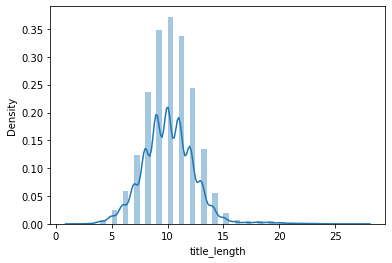

In [54]:
sns.distplot(train["title_length"].append(test["title_length"]))

### первая модель

In [55]:
pipe = pipeline(model="Tatyana/rubert-base-cased-sentiment-new", return_all_scores=True, device=0)
sentiments = []
for title in tqdm(train["title"].append(test["title"])):
    sentiment = pipe(title)
    sentiments.append(sentiment)

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

100%|██████████| 10000/10000 [02:01<00:00, 82.24it/s]


In [56]:
sentiment_matrix = pd.DataFrame([[el["score"] for el in sentiment] for sentiment in sentiments], columns=["Neuteral", "Positive", "Negative"])
sentiment_matrix

,Neuteral,Positive,Negative
0,0.829740,0.112881,0.057379
1,0.830100,0.113010,0.056890
2,0.820121,0.148521,0.031358
3,0.829731,0.113072,0.057196
4,0.795680,0.164480,0.039840
...,...,...,...
9995,0.829743,0.112914,0.057343
9996,0.723366,0.145488,0.131146
9997,0.819810,0.148740,0.031450
9998,0.819456,0.149102,0.031441


In [57]:
train_sentiment = sentiment_matrix.iloc[:7000]
train_sentiment["document_id"] = train["document_id"]

test_sentiment = sentiment_matrix.iloc[7000:]
test_sentiment["document_id"] = list(test["document_id"])
train_sentiment

,Neuteral,Positive,Negative,document_id
0,0.829740,0.112881,0.057379,624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ
1,0.830100,0.113010,0.056890,620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw
2,0.820121,0.148521,0.031358,620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA
3,0.829731,0.113072,0.057196,6262a5889a79470b78c9ca307UKY2SSZTjCcjhwBzxw37w
4,0.795680,0.164480,0.039840,626678929a79477ca0101568wuMYES90REuV5YhrN75IXg
...,...,...,...,...
6995,0.806475,0.161121,0.032404,61fd479c9a7947848183694751RC_1i5QlGuv7B2FzwTjw
6996,0.392244,0.548340,0.059416,628a8f1c9a79478c64a7dae450tIkSGVSf2O8XQgk_uaHQ
6997,0.829588,0.112863,0.057549,6244cf5e9a79479099346b26tKlqoxQYSmij0ZBrGzebug
6998,0.180544,0.067806,0.751650,627303699a794749b8116abc12JX_3ZDTDu2XHF3k2eJVg


In [58]:
test_sentiment

,Neuteral,Positive,Negative,document_id
7000,0.785542,0.180214,0.034244,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw
7001,0.830043,0.112887,0.057070,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw
7002,0.829690,0.112974,0.057335,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw
7003,0.816050,0.151167,0.032782,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ
7004,0.810187,0.151186,0.038627,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw
...,...,...,...,...
9995,0.829743,0.112914,0.057343,623ba6bc9a79470214cb9418x4OZQ1IjTb27nPAgv5wAZg
9996,0.723366,0.145488,0.131146,624fda1f9a79471a9bd102eetuRTrLPGSZyNbc9_YcBAeQ
9997,0.819810,0.148740,0.031450,6257a6a99a79477eea75b86dtBr3UG9ORW-gOybkVKX6ww
9998,0.819456,0.149102,0.031441,624866d59a7947421716ab46WsGDKyGjTJGRh14eR7UVvw


In [59]:
train =  pd.merge(train, train_sentiment, on="document_id")
test = pd.merge(test, test_sentiment, on="document_id")

In [60]:
train

,document_id,title,publish_date,session,authors,ctr,category,tags,views,depth,...,svd_tags_34,svd_tags_35,svd_tags_36,svd_tags_37,svd_tags_38,svd_tags_39,title_length,Neuteral,Positive,Negative
0,624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ,Европейский банк развития приостановил доступ ...,2022-04-04 10:29:44,2405,[],1.580,2,"['55928d339a794751dc8303d6', '542d1e28cbb20f86...",20460,1.134,...,-0.013047,-0.008298,-0.001420,-0.016103,-0.009816,-0.000240,10,0.829740,0.112881,0.057379
1,620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw,Кремль назвал регулярным процессом учебные зап...,2022-02-18 10:00:39,2724,"['54244e01cbb20f03076b236d','5878a2ec9a7947e53...",1.853,0,"['549d25df9a794775979561d2', '58abcf539a7947f1...",19038,1.142,...,-0.000706,-0.004779,0.041615,0.039419,0.015244,0.004282,8,0.830100,0.113010,0.056890
2,620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA,Госсекретарь Швеции заявила о нежелании вступа...,2022-02-12 04:24:02,5741,[],0.000,0,"['5430f451cbb20f73931ecd05', '5409f15de063daa0...",51151,1.185,...,0.032528,-0.005746,-0.052111,0.030620,-0.011116,-0.013942,12,0.820121,0.148521,0.031358
3,6262a5889a79470b78c9ca307UKY2SSZTjCcjhwBzxw37w,Песков назвал прагматичной выдачу лицензии Газ...,2022-04-22 13:24:55,1049,[],0.000,0,"['5409f297e063daa0f408b11c', '545caa9ecbb20f36...",3782,1.053,...,0.024841,0.010746,-0.000113,0.006798,0.024668,-0.003028,12,0.829731,0.113072,0.057196
4,626678929a79477ca0101568wuMYES90REuV5YhrN75IXg,В Хабаровске задержали главу филиала РАНХиГС п...,2022-04-25 10:42:23,7665,[],0.000,5,"['5409f42ae063daa0f408b5d7', '585c20e19a79470e...",3065,1.063,...,0.000360,-0.013180,0.011582,0.016990,0.001240,0.001370,12,0.795680,0.164480,0.039840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,61fd479c9a7947848183694751RC_1i5QlGuv7B2FzwTjw,"Открытие Олимпиады, новые китайские контракты ...",2022-02-04 16:19:09,763,['5878a2ec9a7947e531faf52c'],2.354,5,"['5c124ef99a79476e9d0352d3', '542c454ecbb20f60...",21738,1.188,...,0.007336,0.047881,0.078265,-0.023659,-0.006874,-0.013336,9,0.806475,0.161121,0.032404
6996,628a8f1c9a79478c64a7dae450tIkSGVSf2O8XQgk_uaHQ,Саудовская Аравия выразила надежду на соглашен...,2022-05-22 20:07:46,762,"['60fa94ed9a7947b7152c986a','5e4663219a794736a...",4.112,3,"['543da39fcbb20f2fe7e8a83a', '59d3879e9a794726...",8377,1.056,...,0.001027,-0.002604,-0.006326,0.000844,-0.011566,0.003580,10,0.392244,0.548340,0.059416
6997,6244cf5e9a79479099346b26tKlqoxQYSmij0ZBrGzebug,Брюс Уиллис завершит актерскую карьеру из-за б...,2022-03-30 21:59:02,7228,[],5.125,5,"['59e769a09a794784016dab04', '544539facbb20f34...",37004,1.176,...,0.002176,-0.003464,0.000585,-0.001157,-0.000479,0.000265,7,0.829588,0.112863,0.057549
6998,627303699a794749b8116abc12JX_3ZDTDu2XHF3k2eJVg,Экс-посол Франции назвал болезненным для Европ...,2022-05-04 23:15:48,258,[],0.000,1,"['59cd72769a7947ba5f3a8ae5', '5409f15ae063daa0...",3450,1.068,...,0.134562,0.054635,-0.062984,0.058666,0.020655,0.092774,12,0.180544,0.067806,0.751650


In [61]:
test

,document_id,title,publish_date,session,authors,ctr,category,tags,svd_authors_0,svd_authors_1,...,svd_tags_34,svd_tags_35,svd_tags_36,svd_tags_37,svd_tags_38,svd_tags_39,title_length,Neuteral,Positive,Negative
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,«Крайне провокационная тема»: как Россия и США...,2022-02-01 17:02:44,2510,[],0.000,0,"['58ca77679a794700b1e37f0a', '5409f1b7e063daa0...",1.000000e+00,-1.361721e-15,...,0.106402,0.086915,0.099905,-0.025882,-0.023446,0.000902,13,0.785542,0.180214,0.034244
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,Власти Херсонской области пообещали сделать ру...,2022-05-24 00:50:55,3427,[],1.598,0,"['5433603acbb20f6e5def0cc5', '5409f420e063daa0...",1.000000e+00,-1.361721e-15,...,-0.030470,-0.030892,0.003767,0.040444,0.006188,-0.005495,8,0.830043,0.112887,0.057070
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,Премьер и президент Финляндии призвали срочно ...,2022-05-12 07:11:51,4312,[],2.006,0,"['5409f270e063daa0f408b0a7', '5409f196e063daa0...",1.000000e+00,-1.361721e-15,...,0.096177,-0.016532,-0.155835,0.105063,-0.137713,-0.004582,10,0.829690,0.112974,0.057335
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,В Госдуму внесли проект о временных администра...,2022-05-19 11:54:35,7405,[],0.000,0,"['5409f145e063daa0f408ad35', '5409f30fe063daa0...",1.000000e+00,-1.361721e-15,...,-0.036738,0.055680,-0.000021,0.005533,-0.011438,0.002543,12,0.816050,0.151167,0.032782
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,Блинкен заявил в ООН о готовности России начат...,2022-02-17 16:28:55,852,['604f2c199a79478ec0029eae'],9.136,0,"['5409f15de063daa0f408ada8', '545d4dcdcbb20fbc...",1.401283e-15,9.986216e-01,...,0.000251,-0.011149,-0.064090,0.027944,-0.073213,0.007211,12,0.810187,0.151186,0.038627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,623ba6bc9a79470214cb9418x4OZQ1IjTb27nPAgv5wAZg,Суд не стал публиковать решение о запрете Face...,2022-03-23 23:28:34,7695,['5bfd1d039a794755995093f8'],1.788,4,"['5409f289e063daa0f408b0da', '54289bd7cbb20f85...",-1.521694e-16,2.808329e-03,...,-0.008669,0.016714,-0.011253,0.005584,0.005493,-0.000670,10,0.829743,0.112914,0.057343
2996,624fda1f9a79471a9bd102eetuRTrLPGSZyNbc9_YcBAeQ,ИT-компания EPAM объявила об уходе из России,2022-04-08 08:07:17,7300,['5e4663219a794736af922488'],4.427,3,"['546240cdcbb20f8a5c90571b', '5409f3e8e063daa0...",-4.070964e-16,2.001604e-05,...,-0.004911,0.004194,-0.003781,0.000596,0.003673,0.009181,7,0.723366,0.145488,0.131146
2997,6257a6a99a79477eea75b86dtBr3UG9ORW-gOybkVKX6ww,МИД сообщил о желании стран ЕАЭС отказаться от...,2022-04-14 05:18:59,7214,[],0.000,1,"['5409f1a3e063daa0f408ae98', '5437f9eccbb20f61...",1.000000e+00,-1.361721e-15,...,0.027072,-0.002982,-0.018622,0.012127,0.048140,-0.030201,13,0.819810,0.148740,0.031450
2998,624866d59a7947421716ab46WsGDKyGjTJGRh14eR7UVvw,Wikileaks сообщила дату заседания суда по экст...,2022-04-02 15:59:06,4238,[],0.000,5,"['54b3fc039a794779915a6c71', '559691229a79471c...",1.000000e+00,-1.361721e-15,...,0.001372,0.000719,-0.000313,0.000841,0.000265,0.000035,12,0.819456,0.149102,0.031441


### вторая модель

In [62]:
pipe = pipeline(model="sismetanin/xlm_roberta_large-ru-sentiment-rusentiment", return_all_scores=True, device=0)
sentiments = []
for title in tqdm(train["title"].append(test["title"])):
    sentiment = pipe(title)
    sentiments.append(sentiment)

Downloading:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

100%|██████████| 10000/10000 [03:09<00:00, 52.74it/s]


In [63]:
sentiment_matrix = pd.DataFrame([[el["score"] for el in sentiment] for sentiment in sentiments], columns=[f"label_{i}" for i in range(5)])
sentiment_matrix

,label_0,label_1,label_2,label_3,label_4
0,0.004207,0.993182,0.000089,0.002367,0.000156
1,0.000739,0.995949,0.000225,0.002981,0.000106
2,0.001354,0.995641,0.000118,0.002737,0.000150
3,0.000340,0.997440,0.000254,0.001805,0.000161
4,0.001875,0.996735,0.000100,0.001015,0.000274
...,...,...,...,...,...
9995,0.001838,0.996562,0.000130,0.001348,0.000122
9996,0.003348,0.993775,0.000170,0.002503,0.000204
9997,0.000449,0.997666,0.000148,0.001491,0.000246
9998,0.000309,0.998302,0.000173,0.001113,0.000104


In [64]:
train_sentiment = sentiment_matrix.iloc[:7000]
train_sentiment["document_id"] = train["document_id"]

test_sentiment = sentiment_matrix.iloc[7000:]
test_sentiment["document_id"] = list(test["document_id"])
train_sentiment

,label_0,label_1,label_2,label_3,label_4,document_id
0,0.004207,0.993182,0.000089,0.002367,0.000156,624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ
1,0.000739,0.995949,0.000225,0.002981,0.000106,620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw
2,0.001354,0.995641,0.000118,0.002737,0.000150,620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA
3,0.000340,0.997440,0.000254,0.001805,0.000161,6262a5889a79470b78c9ca307UKY2SSZTjCcjhwBzxw37w
4,0.001875,0.996735,0.000100,0.001015,0.000274,626678929a79477ca0101568wuMYES90REuV5YhrN75IXg
...,...,...,...,...,...,...
6995,0.000439,0.998157,0.000366,0.000880,0.000159,61fd479c9a7947848183694751RC_1i5QlGuv7B2FzwTjw
6996,0.000219,0.996483,0.000715,0.002407,0.000175,628a8f1c9a79478c64a7dae450tIkSGVSf2O8XQgk_uaHQ
6997,0.062139,0.929567,0.000210,0.007756,0.000327,6244cf5e9a79479099346b26tKlqoxQYSmij0ZBrGzebug
6998,0.001742,0.995085,0.000095,0.002942,0.000137,627303699a794749b8116abc12JX_3ZDTDu2XHF3k2eJVg


In [65]:
test_sentiment

,label_0,label_1,label_2,label_3,label_4,document_id
7000,0.001769,0.996157,0.000125,0.001739,0.000210,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw
7001,0.000459,0.997807,0.000354,0.001307,0.000073,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw
7002,0.000289,0.996407,0.000517,0.002690,0.000098,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw
7003,0.000323,0.998489,0.000187,0.000882,0.000119,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ
7004,0.010708,0.985095,0.000144,0.003844,0.000208,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw
...,...,...,...,...,...,...
9995,0.001838,0.996562,0.000130,0.001348,0.000122,623ba6bc9a79470214cb9418x4OZQ1IjTb27nPAgv5wAZg
9996,0.003348,0.993775,0.000170,0.002503,0.000204,624fda1f9a79471a9bd102eetuRTrLPGSZyNbc9_YcBAeQ
9997,0.000449,0.997666,0.000148,0.001491,0.000246,6257a6a99a79477eea75b86dtBr3UG9ORW-gOybkVKX6ww
9998,0.000309,0.998302,0.000173,0.001113,0.000104,624866d59a7947421716ab46WsGDKyGjTJGRh14eR7UVvw


In [66]:
train =  pd.merge(train, train_sentiment, on="document_id")
test = pd.merge(test, test_sentiment, on="document_id")

### третья модель

In [67]:
pipe = pipeline(model="saattrupdan/verdict-classifier", return_all_scores=True, device=0)
sentiments = []
for title in tqdm(train["title"].append(test["title"])):
    sentiment = pipe(title)
    sentiments.append(sentiment)

Downloading:   0%|          | 0.00/3.64k [00:00<?, ?B/s]

100%|██████████| 10000/10000 [01:47<00:00, 93.24it/s]


In [68]:
sentiment_matrix = pd.DataFrame([[el["score"] for el in sentiment] for sentiment in sentiments], columns=["other", "misinformation", "factual"])
sentiment_matrix

,other,misinformation,factual
0,0.000009,0.000231,0.999760
1,0.000020,0.539458,0.460523
2,0.000011,0.000335,0.999655
3,0.000023,0.003585,0.996392
4,0.000015,0.892358,0.107626
...,...,...,...
9995,0.000025,0.000627,0.999348
9996,0.000017,0.000085,0.999898
9997,0.000014,0.000094,0.999892
9998,0.000022,0.000070,0.999907


In [69]:
train_sentiment = sentiment_matrix.iloc[:7000]
train_sentiment["document_id"] = train["document_id"]

test_sentiment = sentiment_matrix.iloc[7000:]
test_sentiment["document_id"] = list(test["document_id"])
train_sentiment

,other,misinformation,factual,document_id
0,0.000009,0.000231,0.999760,624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ
1,0.000020,0.539458,0.460523,620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw
2,0.000011,0.000335,0.999655,620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA
3,0.000023,0.003585,0.996392,6262a5889a79470b78c9ca307UKY2SSZTjCcjhwBzxw37w
4,0.000015,0.892358,0.107626,626678929a79477ca0101568wuMYES90REuV5YhrN75IXg
...,...,...,...,...
6995,0.000013,0.013307,0.986680,61fd479c9a7947848183694751RC_1i5QlGuv7B2FzwTjw
6996,0.000010,0.000389,0.999601,628a8f1c9a79478c64a7dae450tIkSGVSf2O8XQgk_uaHQ
6997,0.000035,0.000137,0.999829,6244cf5e9a79479099346b26tKlqoxQYSmij0ZBrGzebug
6998,0.000020,0.035183,0.964798,627303699a794749b8116abc12JX_3ZDTDu2XHF3k2eJVg


In [70]:
test_sentiment

,other,misinformation,factual,document_id
7000,0.000010,0.000201,0.999790,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw
7001,0.000022,0.000155,0.999823,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw
7002,0.000021,0.000100,0.999879,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw
7003,0.000017,0.000277,0.999706,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ
7004,0.000015,0.000301,0.999684,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw
...,...,...,...,...
9995,0.000025,0.000627,0.999348,623ba6bc9a79470214cb9418x4OZQ1IjTb27nPAgv5wAZg
9996,0.000017,0.000085,0.999898,624fda1f9a79471a9bd102eetuRTrLPGSZyNbc9_YcBAeQ
9997,0.000014,0.000094,0.999892,6257a6a99a79477eea75b86dtBr3UG9ORW-gOybkVKX6ww
9998,0.000022,0.000070,0.999907,624866d59a7947421716ab46WsGDKyGjTJGRh14eR7UVvw


In [71]:
train =  pd.merge(train, train_sentiment, on="document_id")
test = pd.merge(test, test_sentiment, on="document_id")

### Текстовые признаки

In [72]:
import torch
from torch import nn

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

def preprocess(sentence: str):
    sentence = ''.join(map(lambda c: c if c.isalpha() else ' ', sentence))
    return sentence


def tokenize(sentences: list) -> tuple:
    input_ids = []
    attention_masks = []
    for sentence in tqdm(sentences):
        encoded_dict = tokenizer.encode_plus(
                            sentence,                  
                            add_special_tokens = True,
                            max_length=24,           
                            truncation = True,
                            pad_to_max_length = True,
                            return_attention_mask = True,
                            return_tensors="pt", 
                        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return input_ids, attention_masks


input_ids, attention_masks = tokenize(list(map(preprocess, list(train["title"].append(test["title"])))))

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

dataset = TensorDataset(input_ids, attention_masks)
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")
model.to(device)


def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0].detach() #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


predictions = []

for batch in tqdm(dataloader):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)

    with torch.no_grad():        
        output = model(
            b_input_ids, 
            attention_mask=b_input_mask
        )

        pooled_output = mean_pooling(output, b_input_mask).detach().cpu().numpy()
        predictions.append(pooled_output)

preds = np.vstack(predictions)
preds

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=32, algorithm="arpack").fit(preds[:7000])
train_svd_titles = svd.transform(preds[:7000])
test_svd_titles = svd.transform(preds[7000:])

train_svd_titles = pd.DataFrame(train_svd_titles, columns=[f"sbert_title_svd_{i}" for i in range(32)])
train_svd_titles["document_id"] = train["document_id"]

test_svd_titles = pd.DataFrame(test_svd_titles, columns=[f"sbert_title_svd_{i}" for i in range(32)])
test_svd_titles["document_id"] = list(test["document_id"])
test_svd_titles

train =  pd.merge(train, train_svd_titles, on="document_id")
test = pd.merge(test, test_svd_titles, on="document_id")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


100%|██████████| 10000/10000 [00:02<00:00, 4884.81it/s]
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1250/1250 [00:16<00:00, 77.15it/s]


## Time features

In [73]:
train['day'] = pd.to_datetime(train['publish_date']).dt.strftime("%d").astype(int)
train['mounth'] = pd.to_datetime(train['publish_date']).dt.strftime("%m").astype(int)
train['year'] = pd.to_datetime(train['publish_date']).dt.strftime("%y").astype(int)
train["year_month"] = train["publish_date"].apply(lambda x: x.split()[0][:-3])
train["date"] = pd.to_datetime(train["publish_date"].apply(lambda x: x.split()[0]))
train["weekday"] = pd.to_datetime(train["publish_date"]).dt.weekday.astype(int)
train["timestamp"] = pd.to_datetime(train["publish_date"]).astype(int) / 1000000000

test['day'] = pd.to_datetime(test['publish_date']).dt.strftime("%d").astype(int)
test['mounth'] = pd.to_datetime(test['publish_date']).dt.strftime("%m").astype(int)
test['year'] = pd.to_datetime(test['publish_date']).dt.strftime("%y").astype(int)
test["year_month"] = test["publish_date"].apply(lambda x: x.split()[0][:-3])
test["date"] = pd.to_datetime(test["publish_date"].apply(lambda x: x.split()[0]))
test["weekday"] = pd.to_datetime(test["publish_date"]).dt.weekday.astype(int)
test["timestamp"] = pd.to_datetime(test["publish_date"]).astype(int) / 1000000000

year_month_le = LabelEncoder()
year_month_le.fit(sorted(list(train["year_month"].append(test["year_month"]))))
train["year_month"] = year_month_le.transform(train["year_month"])
test["year_month"] = year_month_le.transform(test["year_month"])

In [74]:
train.head(3)

,document_id,title,publish_date,session,authors,ctr,category,tags,views,depth,...,sbert_title_svd_29,sbert_title_svd_30,sbert_title_svd_31,day,mounth,year,year_month,date,weekday,timestamp
0,624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ,Европейский банк развития приостановил доступ ...,2022-04-04 10:29:44,2405,[],1.580,2,"['55928d339a794751dc8303d6', '542d1e28cbb20f86...",20460,1.134,...,-0.516543,0.231170,0.537363,4,4,22,10,2022-04-04,0,1.649068e+09
1,620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw,Кремль назвал регулярным процессом учебные зап...,2022-02-18 10:00:39,2724,"['54244e01cbb20f03076b236d','5878a2ec9a7947e53...",1.853,0,"['549d25df9a794775979561d2', '58abcf539a7947f1...",19038,1.142,...,-0.067962,0.865746,0.616584,18,2,22,8,2022-02-18,4,1.645178e+09
2,620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA,Госсекретарь Швеции заявила о нежелании вступа...,2022-02-12 04:24:02,5741,[],0.000,0,"['5430f451cbb20f73931ecd05', '5409f15de063daa0...",51151,1.185,...,0.269144,0.481495,-1.185303,12,2,22,8,2022-02-12,5,1.644640e+09


In [75]:
ru_holidays = {
    date(2020, 1, 1): 'Новый год',
    date(2020, 1, 2): 'Новый год',
    date(2020, 1, 3): 'Новый год',
    date(2020, 1, 4): 'Новый год',
    date(2020, 1, 5): 'Новый год',
    date(2020, 1, 6): 'Новый год',
    date(2020, 1, 7): 'Православное Рождество',
    date(2020, 1, 8): 'Старый Новый год',
    date(2020, 2, 23): 'День защитника отечества',
    date(2020, 3, 8): 'День женщин',
    date(2020, 5, 1): 'Праздник Весны и Труда',
    date(2020, 5, 9): 'День Победы',
    date(2020, 6, 12): 'День России',
    date(2020, 11, 4): 'День народного единства',

    date(2021, 1, 1): 'Новый год',
    date(2021, 1, 2): 'Новый год',
    date(2021, 1, 3): 'Новый год',
    date(2021, 1, 4): 'Новый год',
    date(2021, 1, 5): 'Новый год',
    date(2021, 1, 6): 'Новый год',
    date(2021, 1, 7): 'Православное Рождество',
    date(2021, 1, 8): 'Старый Новый год',
    date(2021, 2, 23): 'День защитника отечества',
    date(2021, 3, 8): 'День женщин',
    date(2021, 5, 1): 'Праздник Весны и Труда',
    date(2021, 5, 9): 'День Победы',
    date(2021, 6, 12): 'День России',
    date(2021, 11, 4): 'День народного единства',

    date(2022, 1, 1): 'Новый год',
    date(2022, 1, 2): 'Новый год',
    date(2022, 1, 3): 'Новый год',
    date(2022, 1, 4): 'Новый год',
    date(2022, 1, 5): 'Новый год',
    date(2022, 1, 6): 'Новый год',
    date(2022, 1, 7): 'Православное Рождество',
    date(2022, 1, 8): 'Старый Новый год',
    date(2022, 2, 23): 'День защитника отечества',
    date(2022, 3, 8): 'День женщин',
    date(2022, 5, 1): 'Праздник Весны и Труда',
    date(2022, 5, 9): 'День Победы',
    date(2022, 6, 12): 'День России',
    date(2022, 11, 4): 'День народного единства'
}


label_holidays = {
    'Новый год': 0,
    'Православное Рождество': 1,
    'Старый Новый год': 2,
    'День защитника отечества': 3,
    'День женщин': 4,
    'Праздник Весны и Труда': 5,
    'День Победы': 6,
    'День России': 7,
    'День народного единства': 8,
    None: 9
}


def get_holiday(str_date):
    datetime_date = parser.parse(str_date).date()

    if datetime_date in ru_holidays:
        holiday = ru_holidays.get(datetime_date)
    else:
        holiday = None

    holiday = label_holidays.get(holiday)
    
    return holiday


train["holiday"] = train["publish_date"].apply(get_holiday)
test["holiday"] = test["publish_date"].apply(get_holiday)
train.head()

,document_id,title,publish_date,session,authors,ctr,category,tags,views,depth,...,sbert_title_svd_30,sbert_title_svd_31,day,mounth,year,year_month,date,weekday,timestamp,holiday
0,624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ,Европейский банк развития приостановил доступ ...,2022-04-04 10:29:44,2405,[],1.580,2,"['55928d339a794751dc8303d6', '542d1e28cbb20f86...",20460,1.134,...,0.231170,0.537363,4,4,22,10,2022-04-04,0,1.649068e+09,9
1,620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw,Кремль назвал регулярным процессом учебные зап...,2022-02-18 10:00:39,2724,"['54244e01cbb20f03076b236d','5878a2ec9a7947e53...",1.853,0,"['549d25df9a794775979561d2', '58abcf539a7947f1...",19038,1.142,...,0.865746,0.616584,18,2,22,8,2022-02-18,4,1.645178e+09,9
2,620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA,Госсекретарь Швеции заявила о нежелании вступа...,2022-02-12 04:24:02,5741,[],0.000,0,"['5430f451cbb20f73931ecd05', '5409f15de063daa0...",51151,1.185,...,0.481495,-1.185303,12,2,22,8,2022-02-12,5,1.644640e+09,9
3,6262a5889a79470b78c9ca307UKY2SSZTjCcjhwBzxw37w,Песков назвал прагматичной выдачу лицензии Газ...,2022-04-22 13:24:55,1049,[],0.000,0,"['5409f297e063daa0f408b11c', '545caa9ecbb20f36...",3782,1.053,...,-0.266265,0.167446,22,4,22,10,2022-04-22,4,1.650634e+09,9
4,626678929a79477ca0101568wuMYES90REuV5YhrN75IXg,В Хабаровске задержали главу филиала РАНХиГС п...,2022-04-25 10:42:23,7665,[],0.000,5,"['5409f42ae063daa0f408b5d7', '585c20e19a79470e...",3065,1.063,...,-0.152918,0.306909,25,4,22,10,2022-04-25,0,1.650883e+09,9


In [76]:
train["holiday"].value_counts(), test["holiday"].value_counts()

(9    6888
 6      61
 5      51
 Name: holiday, dtype: int64, 9    2950
 5      26
 6      24
 Name: holiday, dtype: int64)

In [77]:
date_le = LabelEncoder()
date_le.fit(sorted(list(train["date"].append(test["date"]).astype(int))))
train["date"] = date_le.transform(train["date"].astype(int))
test["date"] = date_le.transform(test["date"].astype(int))

### Цикличные признаки

In [78]:
def create_cycle(col, period, start_num):
    col = np.sin(2 * np.pi * (col - start_num) / period)
    return col

train['cycle_day'] = create_cycle(train['day'], 31, 0)
train['cycle_mounth'] = create_cycle(train['mounth'], 12, 0)
train["cycle_weekday"] = create_cycle(train["weekday"], 7, 0)

test['cycle_day'] = create_cycle(test['day'], 31, 0)
test['cycle_mounth'] = create_cycle(test['mounth'], 12, 0)
test["cycle_weekday"] = create_cycle(test["weekday"], 7, 0)

### Временные зависимости

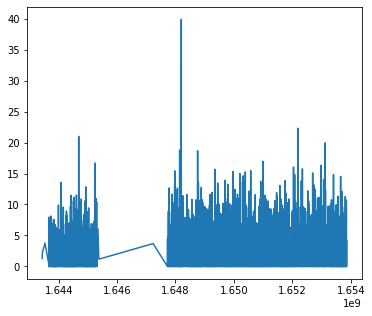

In [79]:
plt.figure(figsize=(6, 5))
plt.plot(train[train["timestamp"] > 1.64e+09].sort_values("timestamp")["timestamp"], train[train["timestamp"] > 1.64e+09].sort_values("timestamp")["ctr"])

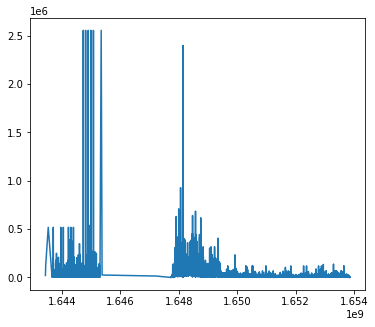

In [80]:
plt.figure(figsize=(6, 5))
plt.plot(train[train["timestamp"] > 1.64e+09].sort_values("timestamp")["timestamp"], train[train["timestamp"] > 1.64e+09].sort_values("timestamp")["views"])

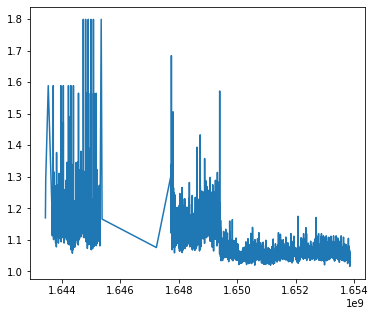

In [81]:
plt.figure(figsize=(6, 5))
plt.plot(train[train["timestamp"] > 1.64e+09].sort_values("timestamp")["timestamp"], train[train["timestamp"] > 1.64e+09].sort_values("timestamp")["depth"])

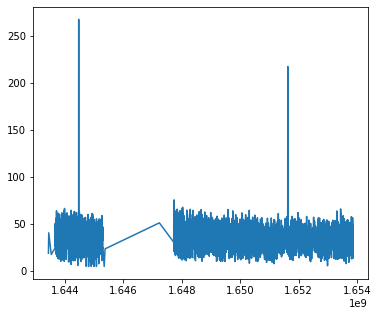

In [82]:
plt.figure(figsize=(6, 5))
plt.plot(train[train["timestamp"] > 1.64e+09].sort_values("timestamp")["timestamp"], train[train["timestamp"] > 1.64e+09].sort_values("timestamp")["full_reads_percent"])

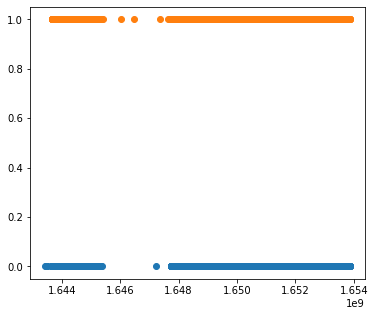

In [83]:
plt.figure(figsize=(6, 5))
plt.scatter(train[train["timestamp"] > 1.64e+09].sort_values("timestamp")["timestamp"], np.zeros(len(train[train["timestamp"] > 1.64e+09].sort_values("timestamp")["timestamp"])))
plt.scatter(test[test["timestamp"] > 1.64e+09].sort_values("timestamp")["timestamp"], np.ones(len(test[test["timestamp"] > 1.64e+09].sort_values("timestamp")["timestamp"])))

## Заполнение ctr

In [84]:
whole_ctr = train["ctr"].append(test["ctr"])
whole_ctr_mean = whole_ctr[whole_ctr > 0].mean()

In [85]:
train["ctr"][train["ctr"] == 0] = whole_ctr_mean
test["ctr"][test["ctr"] == 0] = whole_ctr_mean

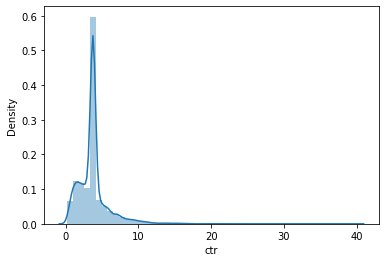

In [86]:
sns.distplot(train["ctr"])

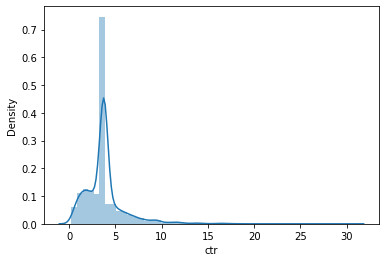

In [87]:
sns.distplot(test["ctr"])

## Агрегации

кодировать не по таргету а по ctr

In [88]:
X_train = train.drop(labels=["views", "depth", "full_reads_percent"], axis=1)
X_test = test
X_train["train"] = np.ones(7000)
X_test["train"] = np.zeros(3000)

X_whole = X_train.append(X_test)

In [89]:
features = ["date", "year", "year_month", "session", "category", "holiday"]

for feature in features:
    mean_ctr = X_whole.groupby([feature])["ctr"].mean().to_frame().rename(columns={"ctr": f"mean_{feature}_ctr"}).reset_index()
    train = train.merge(mean_ctr, how="left", on=[feature])
    test = test.merge(mean_ctr, how="left", on=[feature]) 

for feature in features:
    median_ctr = X_whole.groupby([feature])["ctr"].median().to_frame().rename(columns={"ctr": f"median_{feature}_ctr"}).reset_index()
    train = train.merge(median_ctr, how="left", on=[feature])
    test = test.merge(median_ctr, how="left", on=[feature])  

for feature in features:
    std_ctr = X_whole.groupby([feature])["ctr"].std().to_frame().rename(columns={"ctr": f"std_{feature}_ctr"}).reset_index()
    train = train.merge(std_ctr, how="left", on=[feature])
    test = test.merge(std_ctr, how="left", on=[feature])  

train = train.fillna(0)
test = test.fillna(0)

## Lag признаки

In [90]:
X_whole = X_whole.sort_values("timestamp")

In [91]:
X_whole["ctr_diff"] = X_whole["ctr"].diff()
X_whole["ctr_diff_2"] = X_whole["ctr_diff"].diff()
X_whole = X_whole.fillna(0)

In [92]:
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for i in range(1, n_lags + 1):
        df_n[f"lag_ctr_{i}"] = df_n["ctr"].shift(i)

    df_n = df_n.iloc[n_lags:]
    return df_n

n_lags = 10
X_whole = generate_time_lags(X_whole, n_lags).fillna(0)
X_whole

,document_id,title,publish_date,session,authors,ctr,category,tags,svd_authors_0,svd_authors_1,...,lag_ctr_1,lag_ctr_2,lag_ctr_3,lag_ctr_4,lag_ctr_5,lag_ctr_6,lag_ctr_7,lag_ctr_8,lag_ctr_9,lag_ctr_10
5386,5f8017369a794784407ebca7raq44D-6RY-onlCXAudRiw,Как в России развивается эпидемия COVID. Инфог...,2022-01-29 09:00:53,6990,"['5e677c049a79476cbfa27e1d','5e9ed52a9a79476b7...",2.330000,5,"['5577f72f9a7947f6177effbc', '5e8ec7799a794784...",-7.736671e-16,8.262542e-04,...,1.284000,1.744000,0.903000,1.246000,4.875000,0.670000,5.675000,0.657000,0.668000,1.422000
2929,5e2fe9459a79479d102bada6tIxTQP-GRYiTTwTOEbfyQA,Выявили более 120 тыс. заболевших. Актуальное ...,2022-01-30 08:55:18,7226,"['57c3fa919a7947e69071e942','5b8403979a7947710...",3.759000,5,"['5577f72f9a7947f6177effbc', '5c124ef99a79476e...",6.275627e-17,1.933018e-01,...,2.330000,1.284000,1.744000,0.903000,1.246000,4.875000,0.670000,5.675000,0.657000,0.668000
2066,61f7ab269a79476b1c0d2ed9jhLWGo1ZQjqSdzcqcY9WwQ,В России выросла доля женщин в советах директо...,2022-01-31 21:00:14,5990,['58998a9c9a7947045f27a61d'],0.398000,5,"['54b51fc29a7947a4d027cac0', '54f7daf49a794785...",1.185218e-15,1.017736e-03,...,3.759000,2.330000,1.284000,1.744000,0.903000,1.246000,4.875000,0.670000,5.675000,0.657000
4808,61f7bad29a794775506b2155QkQXjqOoTg29fPOdjoZF6A,Росстат назвал самые дорогие и дешевые города ...,2022-01-31 21:00:19,3470,['60f80a849a79476b9fdcd9ca'],3.089000,1,"['5409f15ae063daa0f408ad90', '542ebbc0cbb20f35...",-6.616798e-16,1.065366e-05,...,0.398000,3.759000,2.330000,1.284000,1.744000,0.903000,1.246000,4.875000,0.670000,5.675000
2832,61f8437a9a79472aecbc3b03qdMFowfWRUGxJjlO06DGRg,Байден определился с кандидатурой посла на Укр...,2022-01-31 21:00:26,6869,['5bfd1d039a794755995093f8'],2.018000,0,"['546e40e7cbb20f1d52dbaa55', '564cb4d69a79473a...",-1.521694e-16,2.808329e-03,...,3.089000,0.398000,3.759000,2.330000,1.284000,1.744000,0.903000,1.246000,4.875000,0.670000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2949,6293c7b99a79476e19dc7ee8jS9gO5ABQsaMYlmZ-u4fTA,"Лавров объяснил, что влияет на сроки спецопера...",2022-05-29 19:27:29,5959,['5a8d11a39a7947c5e1550980'],9.552000,0,['545c81a6cbb20fca592f6ed2'],1.505099e-16,4.507557e-03,...,3.748133,3.748133,3.748133,2.206000,7.402000,3.748133,3.748133,10.723000,7.009000,1.033000
96,6293c7a19a79476e99870dd7VCw7wJgfTKyFEL4JwVcXSQ,Минюст США проверит действия полиции Техаса во...,2022-05-29 19:29:36,4037,[],3.748133,5,"['5409f15ee063daa0f408adb0', '5437017acbb20f0b...",1.000000e+00,-1.361721e-15,...,9.552000,3.748133,3.748133,3.748133,2.206000,7.402000,3.748133,3.748133,10.723000,7.009000
1753,6293c9fc9a79476f81011ed4O9J1S09ZQYyEfz-aAmV0hw,"Лавров заявил, что жители регионов Украины сам...",2022-05-29 19:44:21,3142,['5a8d11a39a7947c5e1550980'],3.116000,0,"['545c81a6cbb20fca592f6ed2', '5409f15de063daa0...",1.505099e-16,4.507557e-03,...,3.748133,9.552000,3.748133,3.748133,3.748133,2.206000,7.402000,3.748133,3.748133,10.723000
692,62931bae9a7947448b3cdab4SRPnZWHSRFmlCCZwce5APg,Что означает объявление Украинской православно...,2022-05-29 20:02:22,3693,['59fc552d9a794760b916c4c7'],4.306000,0,"['55b4bc1e9a7947556dd836f4', '54c9f95b9a79474a...",3.316031e-16,9.746237e-06,...,3.116000,3.748133,9.552000,3.748133,3.748133,3.748133,2.206000,7.402000,3.748133,3.748133


In [93]:
train[["ctr_diff", "ctr_diff_2"]] = X_whole[["ctr_diff", "ctr_diff_2"]][X_whole["train"] == 1]
test[["ctr_diff", "ctr_diff_2"]] = X_whole[["ctr_diff", "ctr_diff_2"]][X_whole["train"] == 0]
train

,document_id,title,publish_date,session,authors,ctr,category,tags,views,depth,...,median_category_ctr,median_holiday_ctr,std_date_ctr,std_year_ctr,std_year_month_ctr,std_session_ctr,std_category_ctr,std_holiday_ctr,ctr_diff,ctr_diff_2
0,624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ,Европейский банк развития приостановил доступ ...,2022-04-04 10:29:44,2405,[],1.580000,2,"['55928d339a794751dc8303d6', '542d1e28cbb20f86...",20460,1.134,...,3.304000,3.748133,1.755601,2.104795,2.178581,1.403363,2.521809,2.101524,-1.936000,0.283000
1,620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw,Кремль назвал регулярным процессом учебные зап...,2022-02-18 10:00:39,2724,"['54244e01cbb20f03076b236d','5878a2ec9a7947e53...",1.853000,0,"['549d25df9a794775979561d2', '58abcf539a7947f1...",19038,1.142,...,3.748133,3.748133,1.644227,2.104795,1.688993,2.274623,2.281729,2.101524,-1.895133,-1.895133
2,620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA,Госсекретарь Швеции заявила о нежелании вступа...,2022-02-12 04:24:02,5741,[],3.748133,0,"['5430f451cbb20f73931ecd05', '5409f15de063daa0...",51151,1.185,...,3.748133,3.748133,3.108365,2.104795,1.688993,0.000000,2.281729,2.101524,2.137133,4.274267
3,6262a5889a79470b78c9ca307UKY2SSZTjCcjhwBzxw37w,Песков назвал прагматичной выдачу лицензии Газ...,2022-04-22 13:24:55,1049,[],3.748133,0,"['5409f297e063daa0f408b11c', '545caa9ecbb20f36...",3782,1.053,...,3.748133,3.748133,2.000646,2.104795,2.178581,0.000000,2.281729,2.101524,-1.422867,0.777133
4,626678929a79477ca0101568wuMYES90REuV5YhrN75IXg,В Хабаровске задержали главу филиала РАНХиГС п...,2022-04-25 10:42:23,7665,[],3.748133,5,"['5409f42ae063daa0f408b5d7', '585c20e19a79470e...",3065,1.063,...,3.748133,3.748133,2.013577,2.104795,2.178581,0.000000,1.415415,2.101524,1.003133,-0.706867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,61fd479c9a7947848183694751RC_1i5QlGuv7B2FzwTjw,"Открытие Олимпиады, новые китайские контракты ...",2022-02-04 16:19:09,763,['5878a2ec9a7947e531faf52c'],2.354000,5,"['5c124ef99a79476e9d0352d3', '542c454ecbb20f60...",21738,1.188,...,3.748133,3.748133,1.194666,2.104795,1.688993,0.398344,1.415415,2.101524,-0.292000,0.810133
6996,628a8f1c9a79478c64a7dae450tIkSGVSf2O8XQgk_uaHQ,Саудовская Аравия выразила надежду на соглашен...,2022-05-22 20:07:46,762,"['60fa94ed9a7947b7152c986a','5e4663219a794736a...",4.112000,3,"['543da39fcbb20f2fe7e8a83a', '59d3879e9a794726...",8377,1.056,...,3.573000,3.748133,2.266713,2.104795,2.175048,3.252918,2.134663,2.101524,-1.542000,-5.773000
6997,6244cf5e9a79479099346b26tKlqoxQYSmij0ZBrGzebug,Брюс Уиллис завершит актерскую карьеру из-за б...,2022-03-30 21:59:02,7228,[],5.125000,5,"['59e769a09a794784016dab04', '544539facbb20f34...",37004,1.176,...,3.748133,3.748133,2.031893,2.104795,2.431225,0.660438,1.415415,2.101524,0.118000,-1.140867
6998,627303699a794749b8116abc12JX_3ZDTDu2XHF3k2eJVg,Экс-посол Франции назвал болезненным для Европ...,2022-05-04 23:15:48,258,[],3.748133,1,"['59cd72769a7947ba5f3a8ae5', '5409f15ae063daa0...",3450,1.068,...,3.748133,3.748133,1.811289,2.104795,2.175048,0.000000,1.972920,2.101524,0.000000,-1.767133


In [94]:
train[[f"lag_ctr_{i}" for i in range(1, n_lags + 1)]] = X_whole[[f"lag_ctr_{i}" for i in range(1, n_lags + 1)]][X_whole["train"] == 1]
test[[f"lag_ctr_{i}" for i in range(1, n_lags + 1)]] = X_whole[[f"lag_ctr_{i}" for i in range(1, n_lags + 1)]][X_whole["train"] == 0]
train

,document_id,title,publish_date,session,authors,ctr,category,tags,views,depth,...,lag_ctr_1,lag_ctr_2,lag_ctr_3,lag_ctr_4,lag_ctr_5,lag_ctr_6,lag_ctr_7,lag_ctr_8,lag_ctr_9,lag_ctr_10
0,624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ,Европейский банк развития приостановил доступ ...,2022-04-04 10:29:44,2405,[],1.580000,2,"['55928d339a794751dc8303d6', '542d1e28cbb20f86...",20460,1.134,...,3.516000,5.735000,3.748133,4.440000,2.612000,3.748133,0.693000,3.748133,5.037000,3.748133
1,620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw,Кремль назвал регулярным процессом учебные зап...,2022-02-18 10:00:39,2724,"['54244e01cbb20f03076b236d','5878a2ec9a7947e53...",1.853000,0,"['549d25df9a794775979561d2', '58abcf539a7947f1...",19038,1.142,...,3.748133,3.748133,1.615000,3.748133,3.748133,1.494000,7.115000,3.650000,3.748133,3.748133
2,620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA,Госсекретарь Швеции заявила о нежелании вступа...,2022-02-12 04:24:02,5741,[],3.748133,0,"['5430f451cbb20f73931ecd05', '5409f15de063daa0...",51151,1.185,...,1.611000,3.748133,7.652000,3.748133,3.748133,1.130000,3.748133,3.748133,3.748133,3.508000
3,6262a5889a79470b78c9ca307UKY2SSZTjCcjhwBzxw37w,Песков назвал прагматичной выдачу лицензии Газ...,2022-04-22 13:24:55,1049,[],3.748133,0,"['5409f297e063daa0f408b11c', '545caa9ecbb20f36...",3782,1.053,...,5.171000,7.371000,0.990000,3.748133,3.748133,2.904000,1.383000,0.335000,1.650000,3.748133
4,626678929a79477ca0101568wuMYES90REuV5YhrN75IXg,В Хабаровске задержали главу филиала РАНХиГС п...,2022-04-25 10:42:23,7665,[],3.748133,5,"['5409f42ae063daa0f408b5d7', '585c20e19a79470e...",3065,1.063,...,2.745000,1.035000,2.861000,2.901000,2.921000,3.748133,3.748133,3.748133,4.913000,3.748133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,61fd479c9a7947848183694751RC_1i5QlGuv7B2FzwTjw,"Открытие Олимпиады, новые китайские контракты ...",2022-02-04 16:19:09,763,['5878a2ec9a7947e531faf52c'],2.354000,5,"['5c124ef99a79476e9d0352d3', '542c454ecbb20f60...",21738,1.188,...,2.646000,3.748133,3.748133,3.748133,3.748133,3.748133,1.232000,3.748133,4.089000,3.748133
6996,628a8f1c9a79478c64a7dae450tIkSGVSf2O8XQgk_uaHQ,Саудовская Аравия выразила надежду на соглашен...,2022-05-22 20:07:46,762,"['60fa94ed9a7947b7152c986a','5e4663219a794736a...",4.112000,3,"['543da39fcbb20f2fe7e8a83a', '59d3879e9a794726...",8377,1.056,...,5.654000,1.423000,6.049000,3.979000,3.748133,2.964000,3.592000,5.020000,5.979000,7.723000
6997,6244cf5e9a79479099346b26tKlqoxQYSmij0ZBrGzebug,Брюс Уиллис завершит актерскую карьеру из-за б...,2022-03-30 21:59:02,7228,[],5.125000,5,"['59e769a09a794784016dab04', '544539facbb20f34...",37004,1.176,...,5.007000,3.748133,1.525000,3.083000,3.748133,4.738000,3.748133,5.549000,1.763000,3.807000
6998,627303699a794749b8116abc12JX_3ZDTDu2XHF3k2eJVg,Экс-посол Франции назвал болезненным для Европ...,2022-05-04 23:15:48,258,[],3.748133,1,"['59cd72769a7947ba5f3a8ae5', '5409f15ae063daa0...",3450,1.068,...,3.748133,1.981000,1.085000,2.982000,2.635000,2.090000,3.748133,2.152000,3.748133,1.661000


# Целевые переменные

## views

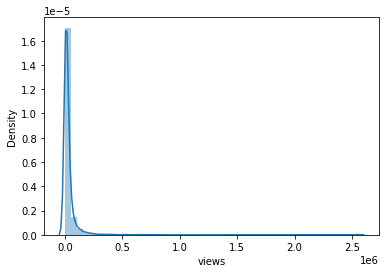

In [95]:
sns.distplot(train["views"])

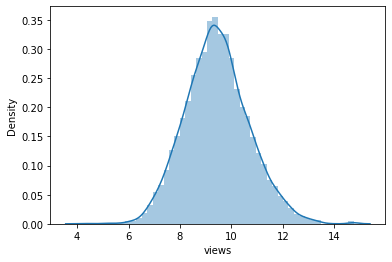

In [96]:
import numpy as np
sns.distplot(np.log(train["views"] + 1))

In [97]:
train["views"].min(), train["views"].mean(), train["views"].median(), train["views"].max()

(65, 30351.617, 11962.0, 2554204)

## depth

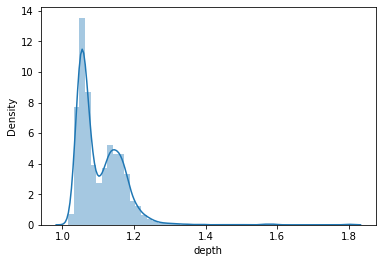

In [98]:
sns.distplot(train["depth"])

In [99]:
train["depth"].min(), train["depth"].mean(), train["depth"].median(), train["depth"].max()

(1.016, 1.1047942857142856, 1.082, 1.799)

## full_reads_percent

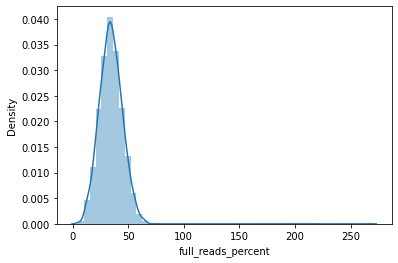

In [100]:
sns.distplot(train["full_reads_percent"])

In [101]:
train["full_reads_percent"].min(), train["full_reads_percent"].mean(), train["full_reads_percent"].median(), train["full_reads_percent"].max()

(4.978, 34.619633, 34.334500000000006, 267.623)

## views * full_reads_percent

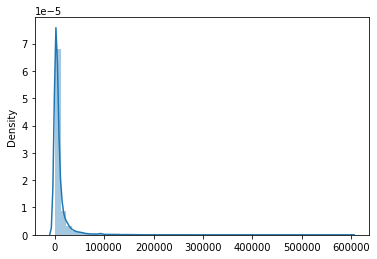

In [102]:
sns.distplot((train["full_reads_percent"] / 100) * train["views"])

## Зависимоти между тергетами

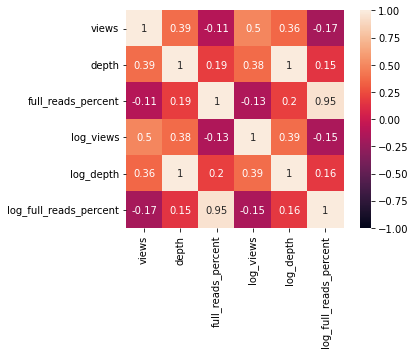

In [103]:
targets = train[["views", "depth", "full_reads_percent"]]
targets["log_views"] = np.log(targets["views"] + 1)
targets["log_depth"] = np.log(targets["depth"] + 1)
targets["log_full_reads_percent"] = np.log(targets["full_reads_percent"] + 1)

sns.heatmap(targets.corr(), vmax=1.0, vmin=-1.0, annot=True, square=True, robust=True)

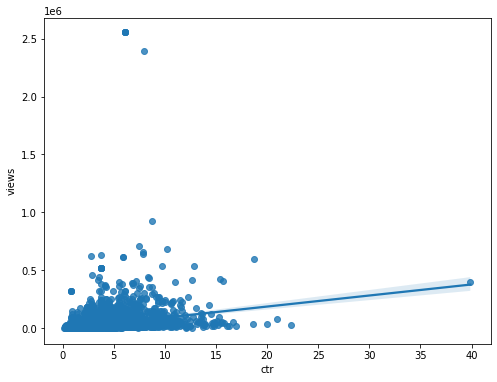

In [104]:
plt.figure(figsize=(8, 6))
sns.regplot(train["ctr"], train["views"])

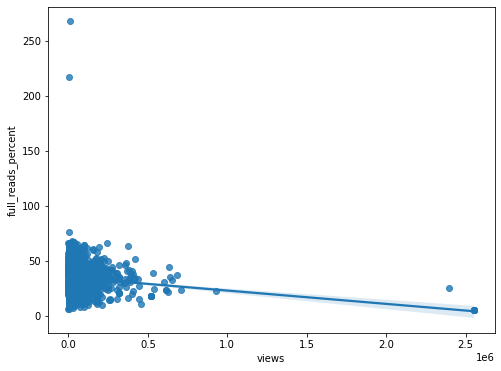

In [105]:
plt.figure(figsize=(8, 6))
sns.regplot(train["views"], train["full_reads_percent"])

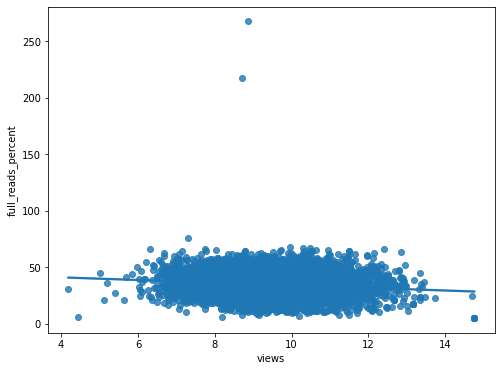

In [106]:
plt.figure(figsize=(8, 6))
sns.regplot(np.log(train["views"] + 1), train["full_reads_percent"])

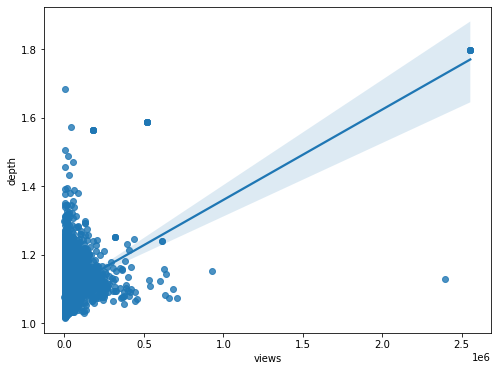

In [107]:
plt.figure(figsize=(8, 6))
sns.regplot(train["views"], train["depth"])

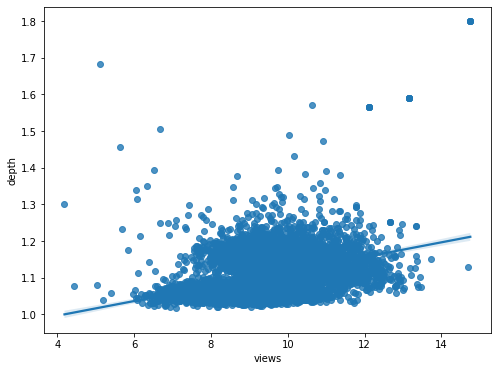

In [108]:
plt.figure(figsize=(8, 6))
sns.regplot(np.log(train["views"] + 1), train["depth"])

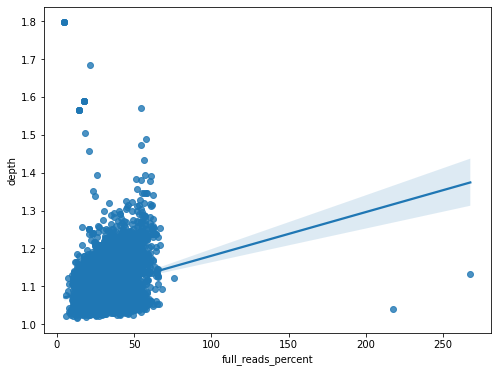

In [109]:
plt.figure(figsize=(8, 6))
sns.regplot(train["full_reads_percent"], train["depth"])

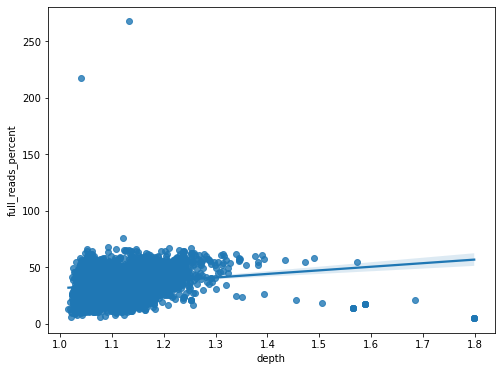

In [110]:
plt.figure(figsize=(8, 6))
sns.regplot(train["depth"], train["full_reads_percent"])

 # Удаление ненужных признаков

In [111]:
list(train.columns)

['document_id',
 'title',
 'publish_date',
 'session',
 'authors',
 'ctr',
 'category',
 'tags',
 'views',
 'depth',
 'full_reads_percent',
 'svd_authors_0',
 'svd_authors_1',
 'svd_authors_2',
 'svd_authors_3',
 'svd_authors_4',
 'svd_authors_5',
 'svd_authors_6',
 'svd_authors_7',
 'svd_authors_8',
 'svd_authors_9',
 'svd_authors_10',
 'svd_authors_11',
 'svd_authors_12',
 'svd_authors_13',
 'svd_authors_14',
 'svd_authors_15',
 'svd_authors_16',
 'svd_authors_17',
 'svd_authors_18',
 'svd_authors_19',
 'svd_tags_0',
 'svd_tags_1',
 'svd_tags_2',
 'svd_tags_3',
 'svd_tags_4',
 'svd_tags_5',
 'svd_tags_6',
 'svd_tags_7',
 'svd_tags_8',
 'svd_tags_9',
 'svd_tags_10',
 'svd_tags_11',
 'svd_tags_12',
 'svd_tags_13',
 'svd_tags_14',
 'svd_tags_15',
 'svd_tags_16',
 'svd_tags_17',
 'svd_tags_18',
 'svd_tags_19',
 'svd_tags_20',
 'svd_tags_21',
 'svd_tags_22',
 'svd_tags_23',
 'svd_tags_24',
 'svd_tags_25',
 'svd_tags_26',
 'svd_tags_27',
 'svd_tags_28',
 'svd_tags_29',
 'svd_tags_30',
 'sv

In [112]:
X = train[set(train.columns) - set(["publish_date", "document_id", "authors", "title", "tags", "views", "depth", "full_reads_percent"])]
y = train[["views", "depth", "full_reads_percent"]]

In [113]:
X["random"] = np.random.random(X.shape[0])

In [114]:
X.shape

(7000, 149)

# Разделенные модели

In [115]:
from catboost import Pool
from sklearn.feature_selection import RFE


def cv(model, X, y, cv_type="kfold", n_splits=5, random_state=777, shuffle=True, log=False, features=None, cat_features=None):
    if features:
        X = X[features]

    scores = []
    feature_importances = []

    if cv_type.lower() == "kfold":
        kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    elif cv_type.lower() == "ts" or cv_type.lower() == "timeseries":
        kf = TimeSeriesSplit(n_splits=n_splits)
    elif cv_type.lower() == "blocking" or cv_type.lower() == "blocked":
        kf = BlockingTimeSeriesSplit(n_splits=n_splits)

    kf.get_n_splits(X)

    all_y = np.zeros(X.shape[0])
    all_preds = np.zeros(X.shape[0])

    for train_index, test_index in tqdm(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        if log:
            print("LOG TARGET")
            y_train = np.log(y_train + 1)

        model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), use_best_model=True)

        fe = model.get_feature_importance(prettified=True)
        feature_importances.append(fe)

        preds = model.predict(X_test)

        if log:
            preds = np.exp(preds) - 1
        
        all_preds[test_index] = preds
        all_y[test_index] = y_test

        score = r2_score(y_test, preds)
        scores.append(score)
        print(score)

    print("SCORE:", sum(scores) / len(scores))
    return feature_importances, all_y, all_preds


def cv_rfe(model, X, y, n_splits=5, random_state=777, shuffle=True, log=False, features=None, cat_features=None):
    if features:
        X = X[features]
    
    summaries = []

    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    kf.get_n_splits(X)

    for train_index, test_index in tqdm(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        train_pool = Pool(X_train, y_train, feature_names=list(X_train.columns))
        test_pool = Pool(X_test, y_test, feature_names=list(X_test.columns))

        if log:
            print("LOG TARGET")
            y_train = np.log(y_train + 1)

        summaries.append(summary)

    return summaries


In [116]:
def get_best_features(feature_importances):
    mean_fe = feature_importances[0].sort_values("Feature Id")
    for i in range(1, 5):
        mean_fe["Importances"] + feature_importances[i].sort_values("Feature Id")["Importances"]

    mean_fe["Importances"] /= 5

    features = []
    for feature in mean_fe.sort_values("Importances", ascending=False)["Feature Id"]:
        if feature == "random":
            break
        features.append(feature)

    return features

## views </br>
### 0.7238216837771565

In [117]:
views_cbr = CatBoostRegressor(verbose=200, n_estimators=5000, learning_rate=0.007, depth=12, loss_function="RMSE", random_state=42, task_type="GPU")

In [118]:
# selector = RFE(views_cbr, n_features_to_select=95, step=1)
# selector = selector.fit(X, y["views"])
# selector.get_feature_names_out

In [119]:
# with open(f'{RBK}/views_features.npy', 'wb') as f:
#     np.save(f, selector.get_feature_names_out)

In [ ]:
views_fe, views_y, global_views_preds = cv(views_cbr, X, y["views"], cv_type="kfold", n_splits=5, random_state=777, log=False)

0it [00:00, ?it/s]Warning: less than 75% gpu memory available for training. Free: 10483.75 Total: 15109.75


0:	learn: 97393.1939339	test: 85949.4403704	best: 85949.4403704 (0)	total: 43.1ms	remaining: 3m 35s
200:	learn: 58066.5982492	test: 52187.2148319	best: 52187.2148319 (200)	total: 1m 5s	remaining: 26m 14s
400:	learn: 43865.3078651	test: 40963.6181259	best: 40963.6181259 (400)	total: 2m 10s	remaining: 25m 2s


In [ ]:
views_features = get_best_features(views_fe)

In [ ]:
views_features

In [ ]:
# views_fe, views_y, global_views_preds = cv(views_cbr, X, y["views"], random_state=42, log=False, features=views_features)

Идея такая, что мы передаем предсказания views для предсказания preds

In [ ]:
# train["views_preds"] = views_preds

## depth
### 0.7866606104691967

In [ ]:
depth_cbr = CatBoostRegressor(verbose=200, n_estimators=5000, learning_rate=0.007, depth=12, loss_function="RMSE", random_state=42, task_type="GPU")
depth_fe, depth_y, depth_preds = cv(depth_cbr, X, y["depth"], random_state=42, log=False)

In [ ]:
depth_features = get_best_features(depth_fe)

In [ ]:
depth_features

In [ ]:
# depth_fe, depth_y, depth_preds = cv(views_cbr, X, y["depth"], random_state=42, log=False, features=depth_features)

In [ ]:
# train["depth_preds"] = depth_preds

## full_reads_percent 
### 0.36857320996313037

Явная линеная зависимость между этой фичей и views => сначала надо предсказывать views и depth

In [ ]:
full_reads_percent_cbr = CatBoostRegressor(verbose=200, n_estimators=5000, learning_rate=0.007, depth=12, loss_function="RMSE", random_state=42, task_type="GPU")
full_reads_percent_fe, full_reads_percent_y, v_preds = cv(full_reads_percent_cbr, X, y["full_reads_percent"], random_state=42, log=False)

In [ ]:
full_reads_percent_features = get_best_features(full_reads_percent_fe)

In [ ]:
full_reads_percent_features

In [ ]:
# full_reads_percent_fe, full_reads_percent_y, full_reads_percent_preds = cv(views_cbr, X, y["full_reads_percent"], random_state=42, log=False, features=full_reads_percent_features)

## Whole validation

In [ ]:
scores = []

kf = KFold(n_splits=5, random_state=777, shuffle=True,)
kf.get_n_splits()

fold = 0

for train_index, test_index in tqdm(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    views_cbr = CatBoostRegressor(verbose=0, n_estimators=5000, learning_rate=0.007, depth=12, loss_function="RMSE", random_state=42, task_type="GPU")
    depth_cbr = CatBoostRegressor(verbose=0, n_estimators=5000, learning_rate=0.007, depth=12, loss_function="RMSE", random_state=42, task_type="GPU")
    full_reads_percent_cbr = CatBoostRegressor(verbose=0, n_estimators=5000, learning_rate=0.007, depth=12, loss_function="RMSE", random_state=42, task_type="GPU")

    views_cbr.fit(X_train[set(views_features)], y_train["views"], \
                  eval_set=(X_test[set(views_features)], y_test["views"]), use_best_model=True)
    
    depth_cbr.fit(X_train[set(depth_features)], y_train["depth"], \
                  eval_set=(X_test[set(depth_features)], y_test["depth"]), use_best_model=True)
    
    full_reads_percent_cbr.fit(X_train[set(full_reads_percent_features)], y_train["full_reads_percent"], \
                               eval_set=(X_test[set(full_reads_percent_features)], y_test["full_reads_percent"]), use_best_model=True)
    
    views_cbr.save_model(f"catboost_v1/views/fold_{fold}.cbm")
    depth_cbr.save_model(f"catboost_v1/depth/fold_{fold}.cbm")
    full_reads_percent_cbr.save_model(f"catboost_v1/full_reads_percent/fold_{fold}.cbm")

    views_preds = views_cbr.predict(X_test[set(views_features)])
    depth_preds = depth_cbr.predict(X_test[set(depth_features)])
    full_reads_percent_preds = full_reads_percent_cbr.predict(X_test[set(full_reads_percent_features)])
    
    score_views = r2_score(y_test["views"], views_preds)
    score_depth = r2_score(y_test["depth"], depth_preds)
    score_frp = r2_score(y_test["full_reads_percent"], full_reads_percent_preds)
    
    score = 0.4 * score_views + 0.3 * score_depth + 0.3 * score_frp
    scores.append(score)
    print(f"FOLD {fold}", score)

    fold += 1

print(sum(scores) / len(scores))

		FOLD 0 0.6657809023471709
		FOLD 1 0.7170228808380836
		FOLD 2 0.6915441185510861
		FOLD 3 0.5862373300290955
		FOLD 4 0.4559488630962826
		0.6233068189723439

## Prediction

In [ ]:
views_stacked_preds = np.zeros((test.shape[0], 5))
depth_stacked_preds = np.zeros((test.shape[0], 5))
full_reads_percent_stacked_preds = np.zeros((test.shape[0], 5))


for fold in range(5):
    print("FOLD", fold)
    views_cbr = CatBoostRegressor(verbose=200, learning_rate=0.005, depth=11, loss_function="RMSE", task_type="GPU").load_model(f"catboost_v1/views/fold_{fold}.cbm")
    depth_cbr = CatBoostRegressor(verbose=200, learning_rate=0.005, depth=11, loss_function="RMSE", task_type="GPU").load_model(f"catboost_v1/depth/fold_{fold}.cbm")
    full_reads_percent_cbr = CatBoostRegressor(verbose=200, learning_rate=0.005, depth=11, loss_function="RMSE", task_type="GPU").load_model(f"catboost_v1/full_reads_percent/fold_{fold}.cbm")

    views_preds = views_cbr.predict(test[set(views_features)])
    depth_preds = depth_cbr.predict(test[set(depth_features)])
    full_reads_percent_preds = full_reads_percent_cbr.predict(test[set(full_reads_percent_features)]) / views_preds * 100

    views_stacked_preds[:, fold] = views_preds
    depth_stacked_preds[:, fold] = depth_preds
    full_reads_percent_stacked_preds[:, fold] = full_reads_percent_preds


In [ ]:
final_views_preds = views_stacked_preds.mean(1)
final_depth_preds = depth_stacked_preds.mean(1)
final_full_reads_percent_preds = full_reads_percent_stacked_preds.mean(1)

In [ ]:
solution = pd.read_csv(f"sample_solution.csv")
solution["views"] = final_views_preds
solution["depth"] = final_depth_preds
solution["full_reads_percent"] = final_full_reads_percent_preds

In [ ]:
solution.to_csv(f"solution.csv", index=False)